# Context

- The goal of this exercise is to predict match outcomes from the game League of Legends created by Riot Games

In [1]:
# Imports
import pandas as pd
import numpy as np
import datetime as dt
from datetime import datetime
import requests
import time

import seaborn as sns
import matplotlib.pyplot as plt 
import datetime as dt
from ydata_profiling import ProfileReport

# ML
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from scipy.stats import randint

# Code required to get data from RIOT API

In [ ]:
apikey = "RGAPI-66c32d53-362e-4c37-ba14-24feb315c569"
# Limit 100 requests every 2 minutes 

In [ ]:
api_url_masters = f"https://na1.api.riotgames.com/lol/league/v4/masterleagues/by-queue/RANKED_SOLO_5x5?api_key={apikey}"

In [ ]:
m = requests.get(api_url_masters)

In [ ]:
masters = m.json()

In [ ]:
masters["tier"] # Confirmation

In [ ]:
len(masters["entries"]) # Number of Players in Master Tier

In [ ]:
import warnings 
warnings.filterwarnings("ignore")

In [ ]:
# Define column names
columns = ['SummonerId', 'SummonerName', 'Tier']
Players = pd.DataFrame(columns=columns)  # Create DF

for entry in masters["entries"]:
    summoner_id = entry["summonerId"]
    summoner_name = entry["summonerName"]
    tier = masters["tier"]
    
    new_row = pd.Series(data={'SummonerId': summoner_id, 'SummonerName': summoner_name, 'Tier': tier})
    Players = Players.append(new_row, ignore_index=True)

print(Players)

In [ ]:
# Repeat same thing for Grandmasters
api_url_gm = f"https://na1.api.riotgames.com/lol/league/v4/grandmasterleagues/by-queue/RANKED_SOLO_5x5?api_key={apikey}"

In [ ]:
gm = requests.get(api_url_gm)

In [ ]:
gmasters = gm.json()

In [ ]:
# 700 Players in Grandmasters
len(gmasters["entries"])

In [ ]:
# Same as before

for entry in gmasters["entries"]:
    summoner_id = entry["summonerId"]
    summoner_name = entry["summonerName"]
    tier = gmasters["tier"]
    new_row = pd.Series(data={'SummonerId': summoner_id, 'SummonerName': summoner_name, 'Tier': tier})
    Players = Players.append(new_row, ignore_index=True)
    
print(Players)

In [ ]:
# repeat for Challenger
api_url_ch = f"https://na1.api.riotgames.com/lol/league/v4/challengerleagues/by-queue/RANKED_SOLO_5x5?api_key={apikey}"

In [ ]:
ch = requests.get(api_url_ch)

In [ ]:
chall = ch.json()

In [ ]:
# 300 PLayers in Challenger
len(chall["entries"])

In [ ]:
# Same as before

for entry in chall["entries"]:
    summoner_id = entry["summonerId"]
    summoner_name = entry["summonerName"]
    tier = chall["tier"]
    
    new_row = pd.Series(data={'SummonerId': summoner_id, 'SummonerName': summoner_name, 'Tier': tier})
    Players = Players.append(new_row, ignore_index=True)

print(Players)

In [ ]:
# Now the Players Dataframe contains the Summoner Data for all of the Players currently in Masters-Challenger ranks
# In the RIOT Api we can only obtain match id's for certain players with their respective puuid's which we dont yet have
# Therefore we now need to pull data for each of the summoners in the Players Dataframe


In [ ]:
Players

In [ ]:
extracted_data = pd.DataFrame(columns=["ID", "PUUID"]) # create new DF 

for index, row in Players.iterrows():  # loop through each row in Players
    summonerId = row["SummonerId"]
    api_url_puuid = f"https://na1.api.riotgames.com/lol/summoner/v4/summoners/{summonerId}?api_key={apikey}"   # input that unique summonerId 
    
    try:
        response = requests.get(api_url_puuid)   # get the special api request for that player
        if response.status_code == 200:
            puuid_data = response.json()      # store the response in json format
            puuid = puuid_data["puuid"]       # assign the values of interest (Puuid)
            player_id = puuid_data["id"]
            extracted_data = extracted_data.append({"ID": player_id, "PUUID": puuid}, ignore_index=True)  # append them to the new dataframe
        else:
            print(f"Error for summonerId {summonerId}: Status code {response.status_code}")
    except Exception as e:
        print(f"Error for summonerId {summonerId}: {str(e)}")

    time.sleep(1.25)  # Sleep timer is needed to deal with the api limit of 100 requests every 2 minutes

print(extracted_data)

# this is the information we need to start getting match data

In [ ]:
# now that we obtained the PUUID we leftjoin to the original Players Dataframe based on on the Summoner ID 

Players = extracted_data.merge(Players, left_on='ID', right_on='SummonerId', how='left')


In [ ]:
Players=Players.drop(["ID"], axis=1) # Drop duplicated column 

In [ ]:
Players # Result 

In [ ]:
# UNIX DATESTAMP converter
# For the API we needed to convert the start date for the matches into UNIX format

date_string = '05/17/2023'
date_object = datetime.strptime(date_string, '%m/%d/%Y')
unix_timestamp = int(date_object.timestamp())
print(unix_timestamp)

In [ ]:
match_data_columns = ["PUUID", "MatchID"]
match_data_df = pd.DataFrame(columns=match_data_columns) # As before, new DF

for index, row in Players.iterrows(): # Iterate over all the rows in Players
    puuid = row["PUUID"]    # Dynamic string input for the api URL
    api_url_matches = f"https://americas.api.riotgames.com/lol/match/v5/matches/by-puuid/{puuid}/ids?startTime={unix_timestamp}&queue=420&type=ranked&start=0&count=100&api_key={apikey}"

    try:
        response = requests.get(api_url_matches)          
        if response.status_code == 200:   # response code 200 = success
            matches_data = response.json()   
            
            # Create a dataframe for the CURRENT player and his matches
            player_match_df = pd.DataFrame(data={"PUUID": [puuid] * len(matches_data), "MatchID": matches_data})
            
            # Append the individual player's matches to the MAIN match data DF
            match_data_df = match_data_df.append(player_match_df, ignore_index=True)
        else:
            print("Error")
    except Exception as e:
        print("Error")
        
    time.sleep(1.25)  # timer as before to adress the api pull limit

print(match_data_df)


In [ ]:
# Since the games are all from the players within a similar rating range
# There are a lot of duplicates in the match ID's because players are playing against each other in the same game
# Therefore we remove them 
matches = match_data_df.drop_duplicates(subset=['MatchID'])

In [ ]:
matches

In [ ]:
matches.to_csv("matches.csv", index=False)

In [ ]:
path = r"./matches.csv"
matches = pd.read_csv(path)

In [ ]:
# Due to long processing time of the next step, we took the decision to split the matches dataframe into five parts
# These will be used to run the following api requests on a seperate computer
# In the meanwhile we continue to develop the Model using matches5, a sample of the data

matches1= matches[0:30000]
matches1.to_csv("matches1.csv", index=False)

matches2= matches[30000:60000]
matches2.to_csv("matches2.csv", index=False)

matches3 = matches[60000:90000]
matches3.to_csv("matches3.csv", index=False)

matches4 = matches[90000:120000]
matches4.to_csv("matches4.csv", index=False)

matches5= matches[120000:]


In [ ]:
# Now we are able to pull the champion information as well as the position of the player in the team. 
# Same approach as before 

# Create new DF
match_data_columns = ["matchID", "teamId", "teamPosition", "championName", "Win"]
match_data_df = pd.DataFrame(columns=match_data_columns)

for index, row in matches5.iterrows():  #change "matches5" for the other sets if desired
    matchId = row["MatchID"]   # extract the match id for the current row
    api_url = f"https://americas.api.riotgames.com/lol/match/v5/matches/{matchId}?api_key={apikey}"
    # input it into the dynamic string api_url

    try:
        response = requests.get(api_url)
        if response.status_code == 200:   # if success then continue
            match_data = response.json()["info"]  # already go into the subdictionary 

            for participant in match_data["participants"]:    # there are 10 participants for each game 
                player_match_df = pd.DataFrame(data={
                    "matchID": [matchId],      # store the data of interest
                    "teamId": participant["teamId"],
                    "teamPosition": participant["teamPosition"],
                    "championName": participant["championName"], 
                    "Win" : participant["win"]
                })

                match_data_df = match_data_df.append(player_match_df, ignore_index=True)    # append the extracted data to the Dataframe
        else:
            print("Error")
    except Exception as e:
        print("Error")

    time.sleep(1.25)  # Sleep timer for api limit

print(match_data_df)

# Dataframe manipulations

- Above code was primarily concerned with obtaining necessary data about matches, players & champions (charachters) played
- From here on out we start setting up the data to begin creating an algorithm that will help us predict match outcomes

In [2]:
path1 = r"./matches1_arpan.csv"
m1 = pd.read_csv(path1) # read the file once it finished running on seperate computer

In [3]:
path2 = r"./matches2_arpan.csv"
m2 = pd.read_csv(path2)  # Same

In [4]:
path3 = r"./matches3_arpan.csv"
m3 = pd.read_csv(path3)  # Same

In [5]:
path4 = r"./matches4_arpan.csv"
m4 = pd.read_csv(path4)  # Same

In [6]:
# Combine all the dataframes
match_data_save = pd.concat([m1, m2, m3, m4], ignore_index=True)

In [7]:
# Check for nulls             
match_data_save.info()
match_data_save.isnull().sum(axis = 0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 799950 entries, 0 to 799949
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   matchID       799950 non-null  object
 1   teamId        799950 non-null  int64 
 2   teamPosition  799718 non-null  object
 3   championName  799950 non-null  object
 4   Win           799950 non-null  bool  
dtypes: bool(1), int64(1), object(3)
memory usage: 25.2+ MB


matchID           0
teamId            0
teamPosition    232
championName      0
Win               0
dtype: int64

In [8]:
# obtain rows that contain nulls
match_data_t_null = match_data_save[match_data_save.isnull().any(axis=1)]

In [9]:
match_data_t_null 

,matchID,teamId,teamPosition,championName,Win
292,NA1_4738427685,100,NaN,Lux,False
2235,NA1_4750455817,200,NaN,Kennen,False
16306,NA1_4740370355,200,NaN,Shaco,False
16989,NA1_4682422702,200,NaN,Amumu,False
33096,NA1_4725660174,200,NaN,Zac,False
...,...,...,...,...,...
777624,NA1_4734011198,100,NaN,Alistar,False
778386,NA1_4724407062,200,NaN,RekSai,False
784439,NA1_4747065031,200,NaN,Maokai,False
791095,NA1_4726426985,200,NaN,Akshan,False


In [10]:
# Making a set for the match ID's that contain nulls
match_ids_to_remove = set(match_data_t_null['matchID'])

In [11]:
match_data = match_data_save[~match_data_save['matchID'].isin(match_ids_to_remove)]

In [12]:
match_data  # Removed all matchId's with nulls 

,matchID,teamId,teamPosition,championName,Win
0,NA1_4742429918,100,TOP,Garen,True
1,NA1_4742429918,100,JUNGLE,Nunu,True
2,NA1_4742429918,100,MIDDLE,Talon,True
3,NA1_4742429918,100,BOTTOM,Ezreal,True
4,NA1_4742429918,100,UTILITY,Zilean,True
...,...,...,...,...,...
799945,NA1_4740030955,200,TOP,Kled,True
799946,NA1_4740030955,200,JUNGLE,Taliyah,True
799947,NA1_4740030955,200,MIDDLE,Jayce,True
799948,NA1_4740030955,200,BOTTOM,Ashe,True


In [13]:
match_data.info()
match_data.isnull().sum(axis = 0)
# None left

<class 'pandas.core.frame.DataFrame'>
Int64Index: 797640 entries, 0 to 799949
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   matchID       797640 non-null  object
 1   teamId        797640 non-null  int64 
 2   teamPosition  797640 non-null  object
 3   championName  797640 non-null  object
 4   Win           797640 non-null  bool  
dtypes: bool(1), int64(1), object(3)
memory usage: 31.2+ MB


matchID         0
teamId          0
teamPosition    0
championName    0
Win             0
dtype: int64

In [14]:
# Remove the Server "NA1_"
match_data["matchID"] = match_data["matchID"].str.split("_", expand=True)[1]

C:\Users\arpan\AppData\Local\Temp\ipykernel_23948\4099672030.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  match_data["matchID"] = match_data["matchID"].str.split("_", expand=True)[1]


In [15]:
# Convert to Int
match_data["matchID"] = pd.to_numeric(match_data["matchID"], errors="coerce")

C:\Users\arpan\AppData\Local\Temp\ipykernel_23948\10396548.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  match_data["matchID"] = pd.to_numeric(match_data["matchID"], errors="coerce")


In [16]:
# Convert to Object for encoding
match_data["teamId"]=match_data["teamId"].astype(object)

C:\Users\arpan\AppData\Local\Temp\ipykernel_23948\1572803062.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  match_data["teamId"]=match_data["teamId"].astype(object)


In [17]:
match_data.info() # Datatype is now correct

<class 'pandas.core.frame.DataFrame'>
Int64Index: 797640 entries, 0 to 799949
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   matchID       797640 non-null  int64 
 1   teamId        797640 non-null  object
 2   teamPosition  797640 non-null  object
 3   championName  797640 non-null  object
 4   Win           797640 non-null  bool  
dtypes: bool(1), int64(1), object(3)
memory usage: 31.2+ MB


In [18]:
match_data = match_data.reset_index(drop=True)
# Reset the Index

In [19]:
# Visualization

Text(0.5, 1.0, 'Histogram of Champion Names')

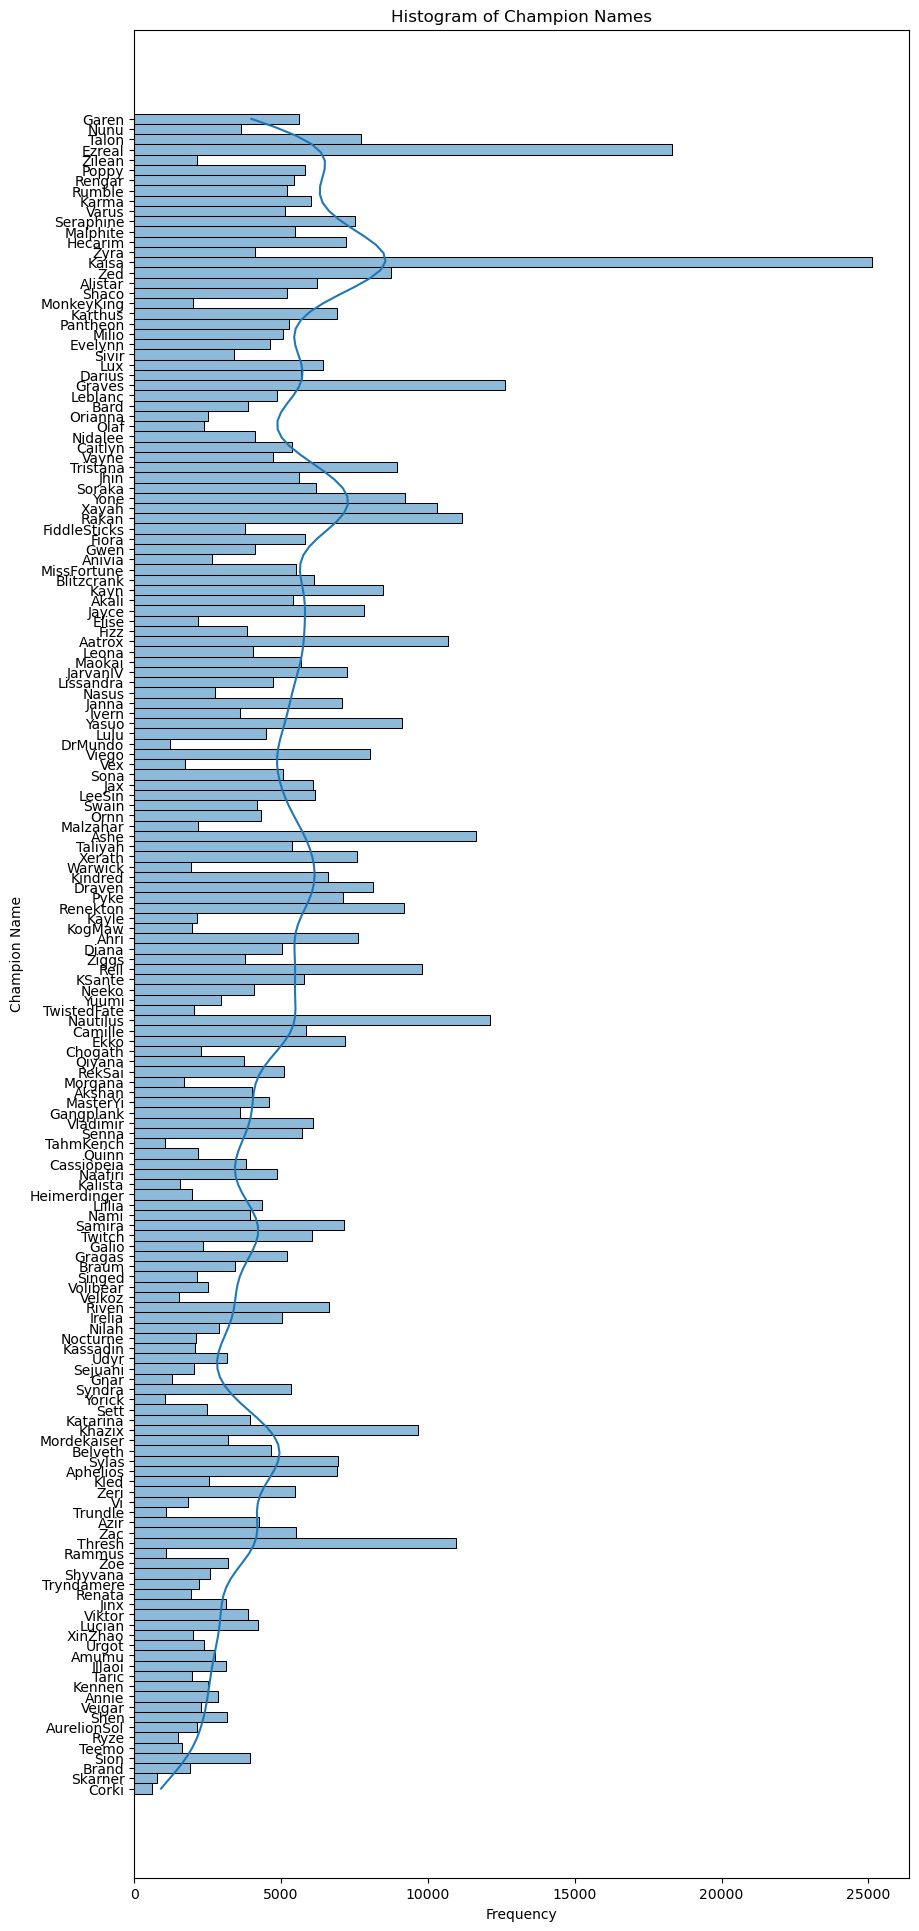

In [20]:
# Flipped Histogram for readability
plt.figure(figsize=(10, 24))

sns.histplot(data=match_data,
             y='championName',  
             kde=True)

plt.xlabel('Frequency')
plt.ylabel('Champion Name')
plt.title('Histogram of Champion Names')

<AxesSubplot:xlabel='teamPosition', ylabel='championName'>

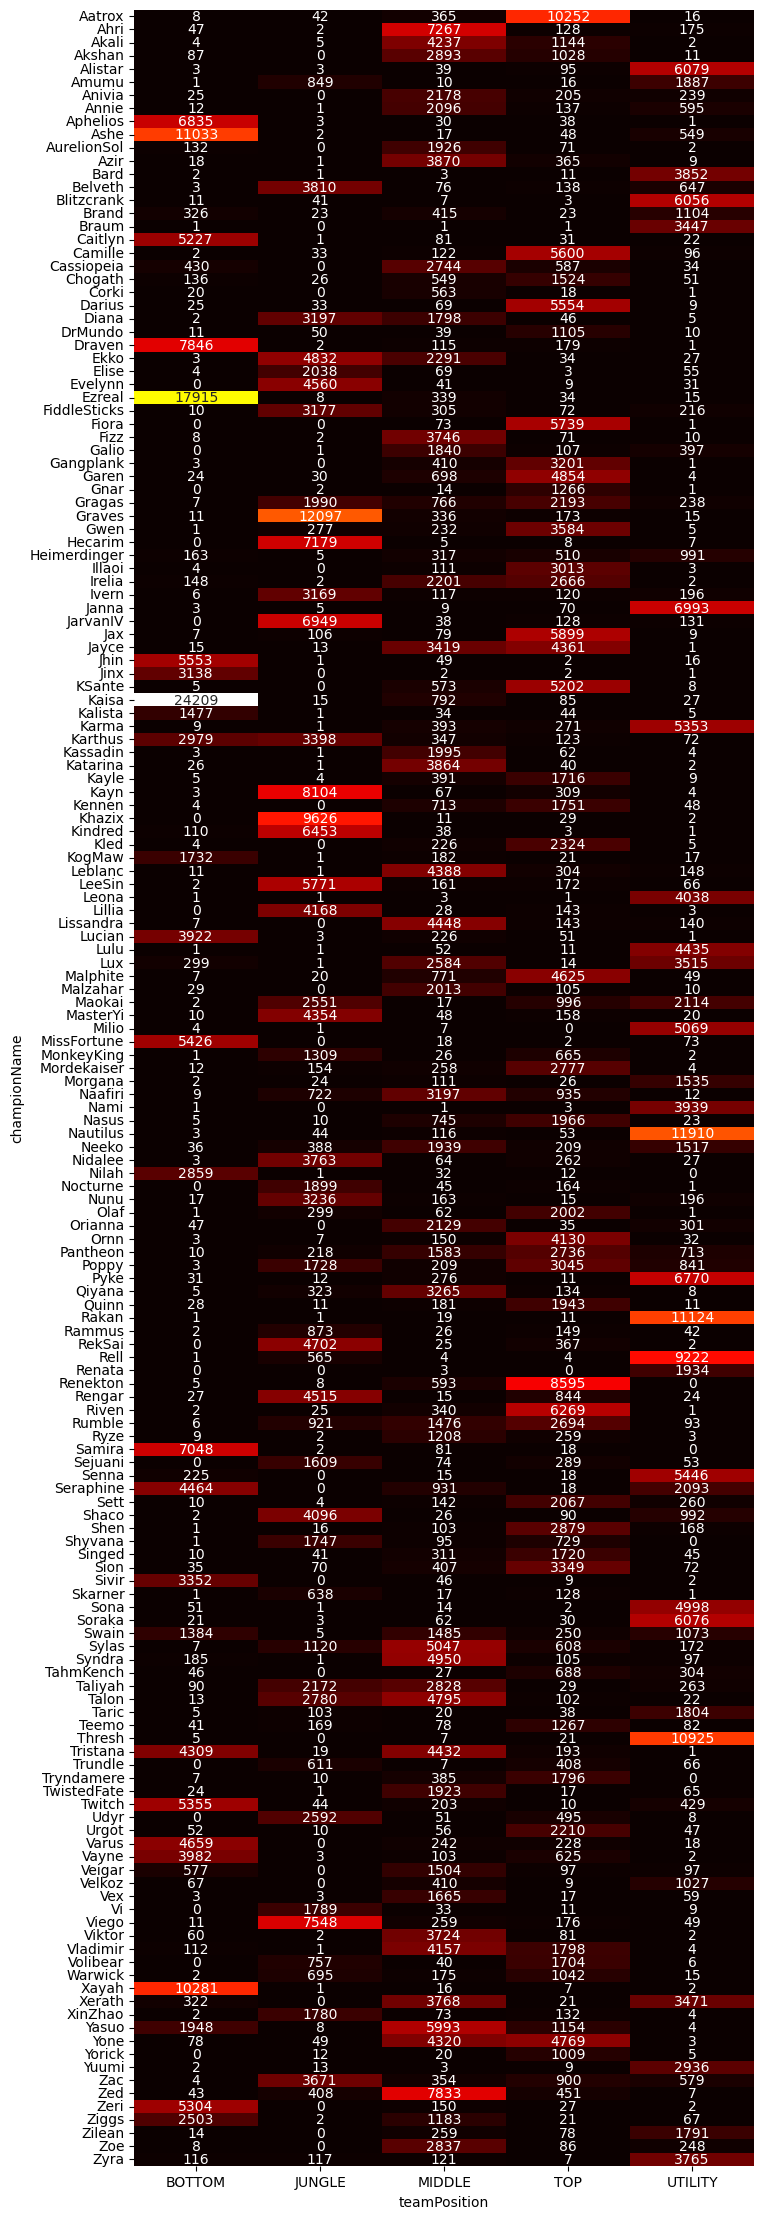

In [21]:
roles=match_data.groupby(['championName','teamPosition'])['teamPosition'].size().unstack().fillna(0)

plt.figure(figsize=(8,28))
sns.heatmap(roles, annot=True, fmt='g', cmap='hot', cbar=False, xticklabels=True, yticklabels=True)

# Feature Engineering

In [22]:
# Obtaining Winrates
champion_occurrences = match_data['championName'].value_counts()
champion_wins = match_data.groupby('championName')['Win'].sum()

win_rates = champion_wins / champion_occurrences

match_data['Winrate'] = match_data['championName'].map(win_rates)

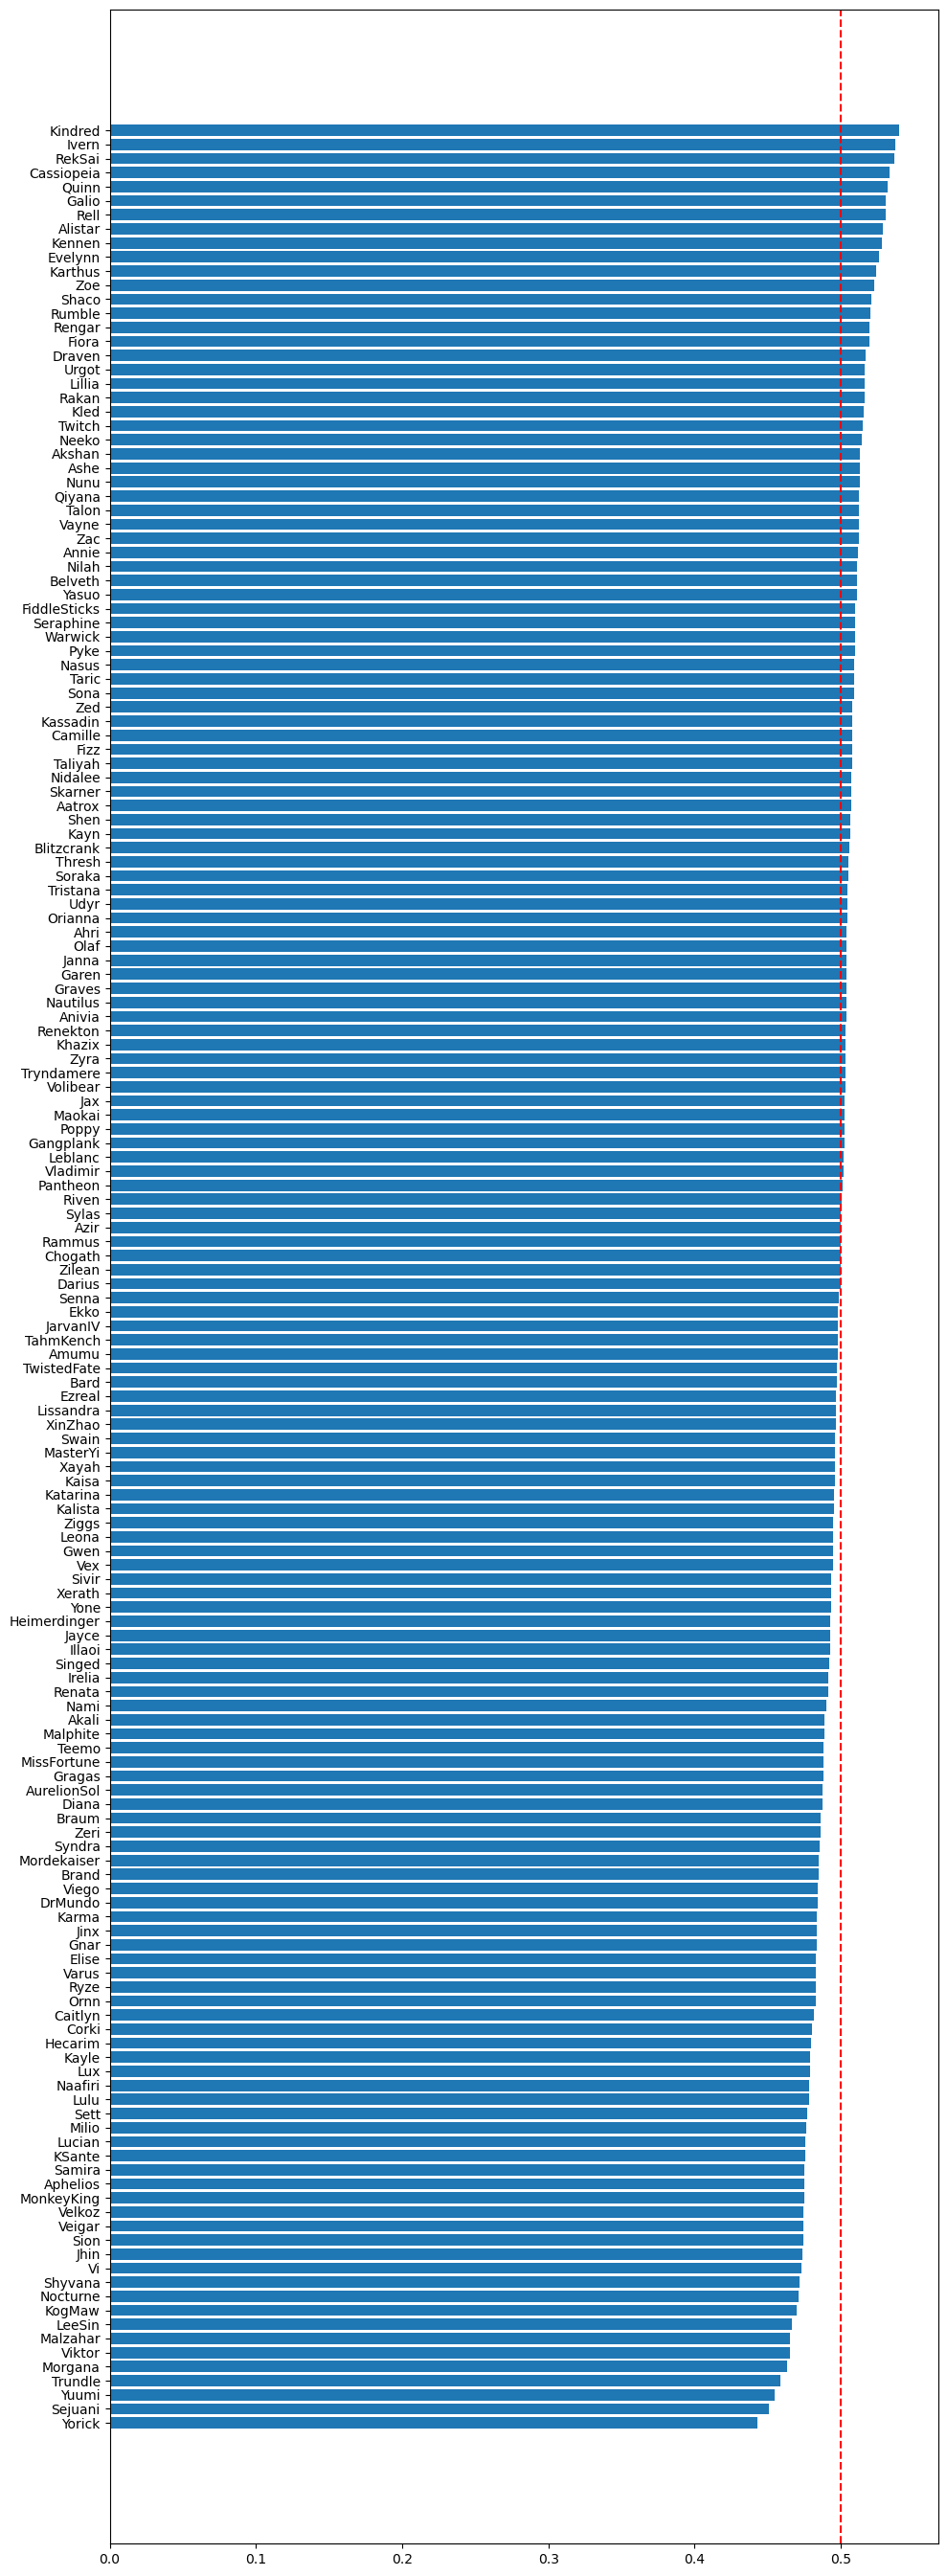

In [23]:

sort = match_data.drop_duplicates(subset='championName').sort_values(by='Winrate', ascending = True)

# Plotting the chart
plt.figure(figsize=(10, 27))
plt.barh(sort['championName'], sort['Winrate'])
plt.axvline(x=0.5, color='red', linestyle='--')
plt.tight_layout()
plt.show()



In [24]:
# Obtaining Popularity rates

Popularity = match_data.groupby('championName')['Win'].count()

pick_rate_indvidual = Popularity / match_data['matchID'].nunique()

match_data['Popularity'] = match_data['championName'].map(pick_rate_indvidual)
match_data

,matchID,teamId,teamPosition,championName,Win,Winrate,Popularity
0,4742429918,100,TOP,Garen,True,0.503922,0.070332
1,4742429918,100,JUNGLE,Nunu,True,0.512821,0.045472
2,4742429918,100,MIDDLE,Talon,True,0.512448,0.096685
3,4742429918,100,BOTTOM,Ezreal,True,0.496860,0.229565
4,4742429918,100,UTILITY,Zilean,True,0.500000,0.026854
...,...,...,...,...,...,...,...
797635,4740030955,200,TOP,Kled,True,0.515436,0.032082
797636,4740030955,200,JUNGLE,Taliyah,True,0.507618,0.067474
797637,4740030955,200,MIDDLE,Jayce,True,0.492893,0.097901
797638,4740030955,200,BOTTOM,Ashe,True,0.513263,0.146043


In [25]:
# Popularity x Win rate

match_data['Popularity*Winrate'] = match_data['Popularity'] * match_data['Winrate']
match_data

,matchID,teamId,teamPosition,championName,Win,Winrate,Popularity,Popularity*Winrate
0,4742429918,100,TOP,Garen,True,0.503922,0.070332,0.035442
1,4742429918,100,JUNGLE,Nunu,True,0.512821,0.045472,0.023319
2,4742429918,100,MIDDLE,Talon,True,0.512448,0.096685,0.049546
3,4742429918,100,BOTTOM,Ezreal,True,0.496860,0.229565,0.114061
4,4742429918,100,UTILITY,Zilean,True,0.500000,0.026854,0.013427
...,...,...,...,...,...,...,...,...
797635,4740030955,200,TOP,Kled,True,0.515436,0.032082,0.016536
797636,4740030955,200,JUNGLE,Taliyah,True,0.507618,0.067474,0.034251
797637,4740030955,200,MIDDLE,Jayce,True,0.492893,0.097901,0.048255
797638,4740030955,200,BOTTOM,Ashe,True,0.513263,0.146043,0.074959


In [26]:
# create a unique identifier for each team by combining matchid & team id 
# this will help with matching features back to the main dataframe later
match_data['match_team_id'] = match_data['matchID'].astype(str) + '_' + match_data['teamId'].astype(str)

In [27]:
# Obtaining botlane combinations and Winrates

BOTDUO = pd.DataFrame()
filtered_data = match_data[(match_data['teamPosition'] == 'BOTTOM') | (match_data['teamPosition'] == 'UTILITY')]

# Extract champion names from team position 'BOTTOM' into a new column 'BOTTOM'
bottom_champions = filtered_data.loc[filtered_data['teamPosition'] == 'BOTTOM', 'championName']
BOTDUO['BOTTOM'] = bottom_champions.reset_index(drop=True)

# Extract champion names from team position 'UTILITY' into a new column 'UTILITY'
utility_champions = filtered_data.loc[filtered_data['teamPosition'] == 'UTILITY', 'championName']
BOTDUO['UTILITY'] = utility_champions.reset_index(drop=True)

# Add the corresponding 'Win' values for each champion
BOTDUO['BOTTOM_Win'] = filtered_data.loc[filtered_data['teamPosition'] == 'BOTTOM', 'Win'].reset_index(drop=True)
BOTDUO['UTILITY_Win'] = filtered_data.loc[filtered_data['teamPosition'] == 'UTILITY', 'Win'].reset_index(drop=True)

# Extract 'matchID' values
match_team_id = filtered_data.loc[filtered_data['teamPosition'] == 'BOTTOM', 'match_team_id']

BOTDUO['match_team_id'] = match_team_id.reset_index(drop=True)

# Create the 'bot_lane' column by combining 'BOTTOM' and 'UTILITY'
BOTDUO['bot_lane'] = BOTDUO['BOTTOM'] + '_' + BOTDUO['UTILITY']

BOTDUO['bot_lane'].value_counts()

####

bot_lane_occurrences = BOTDUO['bot_lane'].value_counts()
bot_lane_wins = BOTDUO.groupby('bot_lane')['BOTTOM_Win'].sum()

bot_lane_win_rates = bot_lane_wins / bot_lane_occurrences

BOTDUO['bot_lane_Winrate'] = BOTDUO['bot_lane'].map(bot_lane_win_rates)

# Popularity

Popularity = BOTDUO.groupby('bot_lane')['BOTTOM_Win'].count()

pick_rate_botduo = Popularity / ((BOTDUO['match_team_id'].nunique())/2)

BOTDUO['bot_lane_Popularity'] = BOTDUO['bot_lane'].map(pick_rate_botduo)

# Create a dictionary to map 'matchID' to the corresponding values in 'BOTDUO'
match_team_id_mapping = BOTDUO.set_index('match_team_id')[['bot_lane_Winrate', 'bot_lane_Popularity']].to_dict()

# Update 'match_data' using the dictionary
match_data['bot_lane_Winrate'] = match_data['match_team_id'].map(match_team_id_mapping['bot_lane_Winrate'])
match_data['bot_lane_Popularity'] = match_data['match_team_id'].map(match_team_id_mapping['bot_lane_Popularity'])


In [28]:
BOTDUO

,BOTTOM,UTILITY,BOTTOM_Win,UTILITY_Win,match_team_id,bot_lane,bot_lane_Winrate,bot_lane_Popularity
0,Ezreal,Zilean,True,True,4742429918_100,Ezreal_Zilean,0.504098,0.003059
1,Varus,Karma,False,False,4742429918_200,Varus_Karma,0.438424,0.002545
2,Seraphine,Zyra,True,True,4742401869_100,Seraphine_Zyra,0.543860,0.000715
3,Kaisa,Alistar,False,False,4742401869_200,Kaisa_Alistar,0.521008,0.014919
4,Varus,Milio,False,False,4742373830_100,Varus_Milio,0.449275,0.001730
...,...,...,...,...,...,...,...,...
159523,Caitlyn,Morgana,True,True,4740434164_200,Caitlyn_Morgana,0.460465,0.002695
159524,Sivir,Soraka,True,True,4740055759_100,Sivir_Soraka,0.509434,0.001993
159525,Ashe,Zac,False,False,4740055759_200,Ashe_Zac,0.441176,0.000426
159526,Jinx,Soraka,False,False,4740030955_100,Jinx_Soraka,0.551181,0.001592


In [29]:
# Repreat procedure for Top & Jungle now

filtered_data = match_data[(match_data['teamPosition'] == 'TOP') | (match_data['teamPosition'] == 'JUNGLE')]

TOP_JNG = pd.DataFrame()

TOP_champions = filtered_data.loc[filtered_data['teamPosition'] == 'TOP', 'championName']
TOP_JNG['TOP'] = TOP_champions.reset_index(drop=True)

JUNGLE_champions = filtered_data.loc[filtered_data['teamPosition'] == 'JUNGLE', 'championName']
TOP_JNG['JUNGLE'] = JUNGLE_champions.reset_index(drop=True)

TOP_JNG['Win'] = filtered_data.loc[filtered_data['teamPosition'] == 'TOP', 'Win'].reset_index(drop=True)

match_team_id = filtered_data.loc[filtered_data['teamPosition'] == 'TOP', 'match_team_id']

TOP_JNG['match_team_id'] = match_team_id.reset_index(drop=True)

# Create the 'Top_Jungle' column by combining 'TOP' and 'JUNGLE'
TOP_JNG['Top_Jungle'] = TOP_JNG['TOP'] + '_' + TOP_JNG['JUNGLE']


# Winrate

Top_Jungle_occurrences = TOP_JNG['Top_Jungle'].value_counts()
Top_Jungle_wins = TOP_JNG.groupby('Top_Jungle')['Win'].sum()

Top_Jungle_win_rates = Top_Jungle_wins / Top_Jungle_occurrences

TOP_JNG['Top_Jungle_Winrate'] = TOP_JNG['Top_Jungle'].map(Top_Jungle_win_rates)

# Popularity

Popularity = TOP_JNG.groupby('Top_Jungle')['Win'].count()

pick_rate_top_jungle = Popularity / ((TOP_JNG['match_team_id'].nunique())/2)

TOP_JNG['Top_Jungle_Popularity'] = TOP_JNG['Top_Jungle'].map(pick_rate_top_jungle)


# Create a dictionary to map 'matchID' to the corresponding values in 'TOP_JNG'
match_team_id_mapping = TOP_JNG.set_index('match_team_id')[['Top_Jungle_Winrate', 'Top_Jungle_Popularity']].to_dict()

# Update 'match_data' using the dictionary
match_data['Top_Jungle_Winrate'] = match_data['match_team_id'].map(match_team_id_mapping['Top_Jungle_Winrate'])
match_data['Top_Jungle_Popularity'] = match_data['match_team_id'].map(match_team_id_mapping['Top_Jungle_Popularity'])


In [30]:
TOP_JNG

,TOP,JUNGLE,Win,match_team_id,Top_Jungle,Top_Jungle_Winrate,Top_Jungle_Popularity
0,Garen,Nunu,True,4742429918_100,Garen_Nunu,0.436364,0.001379
1,Poppy,Rengar,False,4742429918_200,Poppy_Rengar,0.543478,0.001153
2,Garen,Hecarim,True,4742401869_100,Garen_Hecarim,0.470588,0.002771
3,Rumble,Shaco,False,4742401869_200,Rumble_Shaco,0.466667,0.000752
4,MonkeyKing,Karthus,False,4742373830_100,MonkeyKing_Karthus,0.437500,0.000201
...,...,...,...,...,...,...,...
159523,Sett,Khazix,True,4740434164_200,Sett_Khazix,0.568000,0.001567
159524,Aatrox,Kindred,True,4740055759_100,Aatrox_Kindred,0.553525,0.004802
159525,Udyr,Taliyah,False,4740055759_200,Udyr_Taliyah,0.400000,0.000063
159526,Sion,Kindred,False,4740030955_100,Sion_Kindred,0.557823,0.001843


In [31]:
# Repreat procedure for Middle & Jungle now

filtered_data = match_data[(match_data['teamPosition'] == 'MIDDLE') | (match_data['teamPosition'] == 'JUNGLE')]

MID_JNG = pd.DataFrame()

MIDDLE_champions = filtered_data.loc[filtered_data['teamPosition'] == 'MIDDLE', 'championName']
MID_JNG['MIDDLE'] = MIDDLE_champions.reset_index(drop=True)

JUNGLE_champions = filtered_data.loc[filtered_data['teamPosition'] == 'JUNGLE', 'championName']
MID_JNG['JUNGLE'] = JUNGLE_champions.reset_index(drop=True)

MID_JNG['Win'] = filtered_data.loc[filtered_data['teamPosition'] == 'MIDDLE', 'Win'].reset_index(drop=True)

match_team_id = filtered_data.loc[filtered_data['teamPosition'] == 'MIDDLE', 'match_team_id']

MID_JNG['match_team_id'] = match_team_id.reset_index(drop=True)

# Create the 'Top_Jungle' column by combining 'Mid' and 'JUNGLE'
MID_JNG['MIDDLE_Jungle'] = MID_JNG['MIDDLE'] + '_' + MID_JNG['JUNGLE']


# Winrate

MIDDLE_Jungle_occurrences = MID_JNG['MIDDLE_Jungle'].value_counts()
MIDDLE_Jungle_wins = MID_JNG.groupby('MIDDLE_Jungle')['Win'].sum()

MIDDLE_Jungle_win_rates = MIDDLE_Jungle_wins / MIDDLE_Jungle_occurrences

MID_JNG['MIDDLE_Jungle_Winrate'] = MID_JNG['MIDDLE_Jungle'].map(MIDDLE_Jungle_win_rates)


# Popularity

Popularity = MID_JNG.groupby('MIDDLE_Jungle')['Win'].count()

pick_rate_mid_jungle = Popularity / ((MID_JNG['match_team_id'].nunique())/2)

MID_JNG['MIDDLE_Jungle_Popularity'] = MID_JNG['MIDDLE_Jungle'].map(pick_rate_mid_jungle)


# Create a dictionary to map 'matchID' to the corresponding values in 'MID_JNG'
match_team_id_mapping = MID_JNG.set_index('match_team_id')[['MIDDLE_Jungle_Winrate', 'MIDDLE_Jungle_Popularity']].to_dict()

# Update 'match_data' using the dictionary
match_data['MIDDLE_Jungle_Winrate'] = match_data['match_team_id'].map(match_team_id_mapping['MIDDLE_Jungle_Winrate'])
match_data['MIDDLE_Jungle_Popularity'] = match_data['match_team_id'].map(match_team_id_mapping['MIDDLE_Jungle_Popularity'])



In [32]:
MID_JNG

,MIDDLE,JUNGLE,Win,match_team_id,MIDDLE_Jungle,MIDDLE_Jungle_Winrate,MIDDLE_Jungle_Popularity
0,Talon,Nunu,True,4742429918_100,Talon_Nunu,0.579439,0.001341
1,Rumble,Rengar,False,4742429918_200,Rumble_Rengar,0.500000,0.000577
2,Malphite,Hecarim,True,4742401869_100,Malphite_Hecarim,0.620690,0.000364
3,Zed,Shaco,False,4742401869_200,Zed_Shaco,0.548718,0.002445
4,Pantheon,Karthus,False,4742373830_100,Pantheon_Karthus,0.436620,0.000890
...,...,...,...,...,...,...,...
159523,Leblanc,Khazix,True,4740434164_200,Leblanc_Khazix,0.526316,0.004288
159524,Syndra,Kindred,True,4740055759_100,Syndra_Kindred,0.580508,0.002959
159525,Garen,Taliyah,False,4740055759_200,Garen_Taliyah,0.500000,0.000226
159526,Seraphine,Kindred,False,4740030955_100,Seraphine_Kindred,0.500000,0.000627


In [33]:
# Repreat procedure for Middle & Bot_lane now

filtered_data = match_data[(match_data['teamPosition'] == 'MIDDLE') 
                           |(match_data['teamPosition'] == 'BOTTOM') 
                           | (match_data['teamPosition'] == 'UTILITY')]

MID_BOT = pd.DataFrame()

MIDDLE_champions = filtered_data.loc[filtered_data['teamPosition'] == 'MIDDLE', 'championName']
MID_BOT['MIDDLE'] = MIDDLE_champions.reset_index(drop=True)

bottom_champions = filtered_data.loc[filtered_data['teamPosition'] == 'BOTTOM', 'championName']
MID_BOT['BOTTOM'] = bottom_champions.reset_index(drop=True)

utility_champions = filtered_data.loc[filtered_data['teamPosition'] == 'UTILITY', 'championName']
MID_BOT['UTILITY'] = utility_champions.reset_index(drop=True)

MID_BOT['Win'] = filtered_data.loc[filtered_data['teamPosition'] == 'MIDDLE', 'Win'].reset_index(drop=True)

match_team_id = filtered_data.loc[filtered_data['teamPosition'] == 'MIDDLE', 'match_team_id']

MID_BOT['match_team_id'] = match_team_id.reset_index(drop=True)

# Create the 'Top_Jungle' column by combining 'Mid' and 'JUNGLE'
MID_BOT['MIDDLE_bot_lane'] = MID_BOT['MIDDLE'] + '_' + MID_BOT['BOTTOM'] + '_' + MID_BOT['UTILITY']


# Winrate

MIDDLE_bot_lane_occurrences = MID_BOT['MIDDLE_bot_lane'].value_counts()
MIDDLE_bot_lane_wins = MID_BOT.groupby('MIDDLE_bot_lane')['Win'].sum()

MIDDLE_bot_lane_win_rates = MIDDLE_bot_lane_wins / MIDDLE_bot_lane_occurrences

MID_BOT['MIDDLE_bot_lane_Winrate'] = MID_BOT['MIDDLE_bot_lane'].map(MIDDLE_bot_lane_win_rates)

# Popularity

Popularity = MID_BOT.groupby('MIDDLE_bot_lane')['Win'].count()

pick_rate_mid_bot = Popularity / ((MID_BOT['match_team_id'].nunique())/2)

MID_BOT['MIDDLE_bot_lane_Popularity'] = MID_BOT['MIDDLE_bot_lane'].map(pick_rate_mid_bot)

# Create a dictionary to map 'matchID' to the corresponding values in 'MID_BOT'
match_team_id_mapping = MID_BOT.set_index('match_team_id')[['MIDDLE_bot_lane_Winrate', 'MIDDLE_bot_lane_Popularity']].to_dict()

# Update 'match_data' using the dictionary
match_data['MIDDLE_bot_lane_Winrate'] = match_data['match_team_id'].map(match_team_id_mapping['MIDDLE_bot_lane_Winrate'])
match_data['MIDDLE_bot_lane_Popularity'] = match_data['match_team_id'].map(match_team_id_mapping['MIDDLE_bot_lane_Popularity'])



In [34]:
MID_BOT

,MIDDLE,BOTTOM,UTILITY,Win,match_team_id,MIDDLE_bot_lane,MIDDLE_bot_lane_Winrate,MIDDLE_bot_lane_Popularity
0,Talon,Ezreal,Zilean,True,4742429918_100,Talon_Ezreal_Zilean,0.400000,0.000125
1,Rumble,Varus,Karma,False,4742429918_200,Rumble_Varus_Karma,0.666667,0.000038
2,Malphite,Seraphine,Zyra,True,4742401869_100,Malphite_Seraphine_Zyra,0.500000,0.000025
3,Zed,Kaisa,Alistar,False,4742401869_200,Zed_Kaisa_Alistar,0.500000,0.000802
4,Pantheon,Varus,Milio,False,4742373830_100,Pantheon_Varus_Milio,0.333333,0.000038
...,...,...,...,...,...,...,...,...
159523,Leblanc,Caitlyn,Morgana,True,4740434164_200,Leblanc_Caitlyn_Morgana,0.636364,0.000138
159524,Syndra,Sivir,Soraka,True,4740055759_100,Syndra_Sivir_Soraka,0.250000,0.000050
159525,Garen,Ashe,Zac,False,4740055759_200,Garen_Ashe_Zac,0.000000,0.000013
159526,Seraphine,Jinx,Soraka,False,4740030955_100,Seraphine_Jinx_Soraka,0.000000,0.000025


In [35]:
# Repreat procedure for Middle & Top now

filtered_data = match_data[(match_data['teamPosition'] == 'MIDDLE') | (match_data['teamPosition'] == 'TOP')]

MID_TOP = pd.DataFrame()

MIDDLE_champions = filtered_data.loc[filtered_data['teamPosition'] == 'MIDDLE', 'championName']
MID_TOP['MIDDLE'] = MIDDLE_champions.reset_index(drop=True)

TOP_champions = filtered_data.loc[filtered_data['teamPosition'] == 'TOP', 'championName']
MID_TOP['TOP'] = TOP_champions.reset_index(drop=True)

MID_TOP['Win'] = filtered_data.loc[filtered_data['teamPosition'] == 'MIDDLE', 'Win'].reset_index(drop=True)

match_team_id = filtered_data.loc[filtered_data['teamPosition'] == 'MIDDLE', 'match_team_id']

MID_TOP['match_team_id'] = match_team_id.reset_index(drop=True)

# Create the 'Top_Jungle' column by combining 'Mid' and 'JUNGLE'
MID_TOP['MIDDLE_TOP'] = MID_TOP['MIDDLE'] + '_' + MID_TOP['TOP']


# Winrate

MIDDLE_TOP_occurrences = MID_TOP['MIDDLE_TOP'].value_counts()
MIDDLE_TOP_wins = MID_TOP.groupby('MIDDLE_TOP')['Win'].sum()

MIDDLE_TOP_win_rates = MIDDLE_TOP_wins / MIDDLE_TOP_occurrences

MID_TOP['MIDDLE_TOP_Winrate'] = MID_TOP['MIDDLE_TOP'].map(MIDDLE_TOP_win_rates)

MID_TOP

# Popularity

Popularity = MID_TOP.groupby('MIDDLE_TOP')['Win'].count()

pick_rate_mid_top = Popularity / ((MID_TOP['match_team_id'].nunique())/2)

MID_TOP['MIDDLE_TOP_Popularity'] = MID_TOP['MIDDLE_TOP'].map(pick_rate_mid_top)


# Create a dictionary to map 'matchID' to the corresponding values in 'MID_TOP'
match_team_id_mapping = MID_TOP.set_index('match_team_id')[['MIDDLE_TOP_Winrate', 'MIDDLE_TOP_Popularity']].to_dict()

# Update 'match_data' using the dictionary
match_data['MIDDLE_TOP_Winrate'] = match_data['match_team_id'].map(match_team_id_mapping['MIDDLE_TOP_Winrate'])
match_data['MIDDLE_TOP_Popularity'] = match_data['match_team_id'].map(match_team_id_mapping['MIDDLE_TOP_Popularity'])



In [36]:
MID_TOP

,MIDDLE,TOP,Win,match_team_id,MIDDLE_TOP,MIDDLE_TOP_Winrate,MIDDLE_TOP_Popularity
0,Talon,Garen,True,4742429918_100,Talon_Garen,0.576642,0.001718
1,Rumble,Poppy,False,4742429918_200,Rumble_Poppy,0.521739,0.000288
2,Malphite,Garen,True,4742401869_100,Malphite_Garen,0.260870,0.000288
3,Zed,Rumble,False,4742401869_200,Zed_Rumble,0.502392,0.002620
4,Pantheon,MonkeyKing,False,4742373830_100,Pantheon_MonkeyKing,0.250000,0.000050
...,...,...,...,...,...,...,...
159523,Leblanc,Sett,True,4740434164_200,Leblanc_Sett,0.448276,0.000727
159524,Syndra,Aatrox,True,4740055759_100,Syndra_Aatrox,0.525424,0.004438
159525,Garen,Udyr,False,4740055759_200,Garen_Udyr,0.500000,0.000075
159526,Seraphine,Sion,False,4740030955_100,Seraphine_Sion,0.448276,0.000364


In [37]:
## Repreat procedure for Top & Bot_lane now

filtered_data = match_data[(match_data['teamPosition'] == 'TOP')
                           |(match_data['teamPosition'] == 'BOTTOM') 
                           | (match_data['teamPosition'] == 'UTILITY')]

TOP_BOT = pd.DataFrame()

TOP_champions = filtered_data.loc[filtered_data['teamPosition'] == 'TOP', 'championName']
TOP_BOT['TOP'] = TOP_champions.reset_index(drop=True)

bottom_champions = filtered_data.loc[filtered_data['teamPosition'] == 'BOTTOM', 'championName']
TOP_BOT['BOTTOM'] = bottom_champions.reset_index(drop=True)

utility_champions = filtered_data.loc[filtered_data['teamPosition'] == 'UTILITY', 'championName']
TOP_BOT['UTILITY'] = utility_champions.reset_index(drop=True)

TOP_BOT['Win'] = filtered_data.loc[filtered_data['teamPosition'] == 'TOP', 'Win'].reset_index(drop=True)

match_team_id = filtered_data.loc[filtered_data['teamPosition'] == 'TOP', 'match_team_id']

TOP_BOT['match_team_id'] = match_team_id.reset_index(drop=True)

# Create the 'Top_Jungle' column by combining 'Mid' and 'JUNGLE'
TOP_BOT['TOP_bot_lane'] = TOP_BOT['TOP'] + '_' + TOP_BOT['BOTTOM'] + '_' + TOP_BOT['UTILITY']

# Winrate

TOP_bot_lane_occurrences = TOP_BOT['TOP_bot_lane'].value_counts()
TOP_bot_lane_wins = TOP_BOT.groupby('TOP_bot_lane')['Win'].sum()

TOP_bot_lane_win_rates = TOP_bot_lane_wins / TOP_bot_lane_occurrences

TOP_BOT['TOP_bot_lane_Winrate'] = TOP_BOT['TOP_bot_lane'].map(TOP_bot_lane_win_rates)

# Popularity

Popularity = TOP_BOT.groupby('TOP_bot_lane')['Win'].count()

pick_rate_top_bot = Popularity / ((TOP_BOT['match_team_id'].nunique())/2)

TOP_BOT['TOP_bot_lane_Popularity'] = TOP_BOT['TOP_bot_lane'].map(pick_rate_top_bot)


# Create a dictionary to map 'matchID' to the corresponding values in 'TOP_BOT'
match_team_id_mapping = TOP_BOT.set_index('match_team_id')[['TOP_bot_lane_Winrate', 'TOP_bot_lane_Popularity']].to_dict()

# Update 'match_data' using the dictionary
match_data['TOP_bot_lane_Winrate'] = match_data['match_team_id'].map(match_team_id_mapping['TOP_bot_lane_Winrate'])
match_data['TOP_bot_lane_Popularity'] = match_data['match_team_id'].map(match_team_id_mapping['TOP_bot_lane_Popularity'])



In [38]:
TOP_BOT

,TOP,BOTTOM,UTILITY,Win,match_team_id,TOP_bot_lane,TOP_bot_lane_Winrate,TOP_bot_lane_Popularity
0,Garen,Ezreal,Zilean,True,4742429918_100,Garen_Ezreal_Zilean,0.615385,0.000163
1,Poppy,Varus,Karma,False,4742429918_200,Poppy_Varus_Karma,0.000000,0.000038
2,Garen,Seraphine,Zyra,True,4742401869_100,Garen_Seraphine_Zyra,0.750000,0.000050
3,Rumble,Kaisa,Alistar,False,4742401869_200,Rumble_Kaisa_Alistar,0.400000,0.000313
4,MonkeyKing,Varus,Milio,False,4742373830_100,MonkeyKing_Varus_Milio,0.000000,0.000013
...,...,...,...,...,...,...,...,...
159523,Sett,Caitlyn,Morgana,True,4740434164_200,Sett_Caitlyn_Morgana,0.625000,0.000100
159524,Aatrox,Sivir,Soraka,True,4740055759_100,Aatrox_Sivir_Soraka,0.625000,0.000100
159525,Udyr,Ashe,Zac,False,4740055759_200,Udyr_Ashe_Zac,0.000000,0.000013
159526,Sion,Jinx,Soraka,False,4740030955_100,Sion_Jinx_Soraka,0.000000,0.000025


In [39]:
## Repreat procedure for Jungle & Bot_lane now

filtered_data = match_data[(match_data['teamPosition'] == 'JUNGLE')
                           |(match_data['teamPosition'] == 'BOTTOM') 
                           | (match_data['teamPosition'] == 'UTILITY')]

JNG_BOT = pd.DataFrame()

JUNGLE_champions = filtered_data.loc[filtered_data['teamPosition'] == 'JUNGLE', 'championName']
JNG_BOT['JUNGLE'] = JUNGLE_champions.reset_index(drop=True)

bottom_champions = filtered_data.loc[filtered_data['teamPosition'] == 'BOTTOM', 'championName']
JNG_BOT['BOTTOM'] = bottom_champions.reset_index(drop=True)

utility_champions = filtered_data.loc[filtered_data['teamPosition'] == 'UTILITY', 'championName']
JNG_BOT['UTILITY'] = utility_champions.reset_index(drop=True)

JNG_BOT['Win'] = filtered_data.loc[filtered_data['teamPosition'] == 'JUNGLE', 'Win'].reset_index(drop=True)

match_team_id = filtered_data.loc[filtered_data['teamPosition'] == 'JUNGLE', 'match_team_id']

JNG_BOT['match_team_id'] = match_team_id.reset_index(drop=True)

# Create the 'Top_Jungle' column by combining 'Mid' and 'JUNGLE'
JNG_BOT['JUNGLE_bot_lane'] = JNG_BOT['JUNGLE'] + '_' + JNG_BOT['BOTTOM'] + '_' + JNG_BOT['UTILITY']

# Winrate

JUNGLE_bot_lane_occurrences = JNG_BOT['JUNGLE_bot_lane'].value_counts()
JUNGLE_bot_lane_wins = JNG_BOT.groupby('JUNGLE_bot_lane')['Win'].sum()

JUNGLE_bot_lane_win_rates = JUNGLE_bot_lane_wins / JUNGLE_bot_lane_occurrences

JNG_BOT['JUNGLE_bot_lane_Winrate'] = JNG_BOT['JUNGLE_bot_lane'].map(JUNGLE_bot_lane_win_rates)

# Popularity

Popularity = JNG_BOT.groupby('JUNGLE_bot_lane')['Win'].count()

pick_rate_jungle_bot = Popularity / ((JNG_BOT['match_team_id'].nunique())/2)

JNG_BOT['JUNGLE_bot_lane_Popularity'] = JNG_BOT['JUNGLE_bot_lane'].map(pick_rate_jungle_bot)


# Create a dictionary to map 'matchID' to the corresponding values in 'JNG_BOT'
match_team_id_mapping = JNG_BOT.set_index('match_team_id')[['JUNGLE_bot_lane_Winrate', 'JUNGLE_bot_lane_Popularity']].to_dict()

# Update 'match_data' using the dictionary
match_data['JUNGLE_bot_lane_Winrate'] = match_data['match_team_id'].map(match_team_id_mapping['JUNGLE_bot_lane_Winrate'])
match_data['JUNGLE_bot_lane_Popularity'] = match_data['match_team_id'].map(match_team_id_mapping['JUNGLE_bot_lane_Popularity'])


In [40]:
JNG_BOT

,JUNGLE,BOTTOM,UTILITY,Win,match_team_id,JUNGLE_bot_lane,JUNGLE_bot_lane_Winrate,JUNGLE_bot_lane_Popularity
0,Nunu,Ezreal,Zilean,True,4742429918_100,Nunu_Ezreal_Zilean,0.428571,0.000088
1,Rengar,Varus,Karma,False,4742429918_200,Rengar_Varus_Karma,0.444444,0.000113
2,Hecarim,Seraphine,Zyra,True,4742401869_100,Hecarim_Seraphine_Zyra,0.250000,0.000050
3,Shaco,Kaisa,Alistar,False,4742401869_200,Shaco_Kaisa_Alistar,0.620690,0.000364
4,Karthus,Varus,Milio,False,4742373830_100,Karthus_Varus_Milio,0.250000,0.000050
...,...,...,...,...,...,...,...,...
159523,Khazix,Caitlyn,Morgana,True,4740434164_200,Khazix_Caitlyn_Morgana,0.450000,0.000251
159524,Kindred,Sivir,Soraka,True,4740055759_100,Kindred_Sivir_Soraka,0.714286,0.000088
159525,Taliyah,Ashe,Zac,False,4740055759_200,Taliyah_Ashe_Zac,0.000000,0.000013
159526,Kindred,Jinx,Soraka,False,4740030955_100,Kindred_Jinx_Soraka,0.250000,0.000100


In [41]:
match_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 797640 entries, 0 to 797639
Data columns (total 23 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   matchID                     797640 non-null  int64  
 1   teamId                      797640 non-null  object 
 2   teamPosition                797640 non-null  object 
 3   championName                797640 non-null  object 
 4   Win                         797640 non-null  bool   
 5   Winrate                     797640 non-null  float64
 6   Popularity                  797640 non-null  float64
 7   Popularity*Winrate          797640 non-null  float64
 8   match_team_id               797640 non-null  object 
 9   bot_lane_Winrate            797640 non-null  float64
 10  bot_lane_Popularity         797640 non-null  float64
 11  Top_Jungle_Winrate          797640 non-null  float64
 12  Top_Jungle_Popularity       797640 non-null  float64
 13  MIDDLE_Jungle_

In [42]:
# Turn 10 rows with same match ID into one row per match ID

pivoted = match_data.pivot_table(
    index=['matchID', 'teamId'],
    columns=['teamPosition'],
    values=['championName', 'Winrate','Popularity','Popularity*Winrate',
            'bot_lane_Winrate','bot_lane_Popularity',
            'Top_Jungle_Winrate', 'Top_Jungle_Popularity',
            'MIDDLE_Jungle_Winrate','MIDDLE_Jungle_Popularity',
            'MIDDLE_TOP_Winrate', 'MIDDLE_TOP_Popularity',
            'MIDDLE_bot_lane_Winrate','MIDDLE_bot_lane_Popularity',
            'TOP_bot_lane_Winrate', 'TOP_bot_lane_Popularity',
            'JUNGLE_bot_lane_Winrate','JUNGLE_bot_lane_Popularity'],
            
    aggfunc={'championName': 'first', 'Winrate': 'first','Popularity':'first','Popularity*Winrate':'first',
             'bot_lane_Winrate':'first','bot_lane_Popularity':'first',
             'Top_Jungle_Winrate':'first', 'Top_Jungle_Popularity':'first',
             'MIDDLE_Jungle_Winrate':'first','MIDDLE_Jungle_Popularity':'first',
             'MIDDLE_TOP_Winrate':'first', 'MIDDLE_TOP_Popularity':'first',
             'MIDDLE_bot_lane_Winrate':'first','MIDDLE_bot_lane_Popularity':'first',
             'TOP_bot_lane_Winrate':'first', 'TOP_bot_lane_Popularity':'first',
             'JUNGLE_bot_lane_Winrate':'first','JUNGLE_bot_lane_Popularity':'first'})

# Flatten the MultiIndex columns
pivoted.columns = ['{}_{}'.format(col[1], col[0]) for col in pivoted.columns]

# Reset the index to convert matchID and teamId back to columns
pivoted.reset_index(inplace=True)

# Merge blue and red team data
merged_data = pd.merge(
    pivoted[pivoted['teamId'] == 100],
    pivoted[pivoted['teamId'] == 200],
    on='matchID',
    suffixes=('_blue', '_red')
)

In [43]:
for index, row in match_data.iterrows():
    match_id = row['matchID']
    team_id = row['teamId']
    win = row['Win']
    
    # Find the row index in merged_data that corresponds to the current matchID
    merged_index = merged_data.index[merged_data['matchID'] == match_id][0]
    
    # Update the 'blue_win' column in merged_data based on the conditions
    if team_id == 100 and win:
        merged_data.at[merged_index, 'blue_win'] = 1


In [44]:
# Rename columns
merged_data.rename(columns={
    'BOTTOM_JUNGLE_bot_lane_Popularity_blue': 'JNG-BOT_Popularity_blue',
    'BOTTOM_JUNGLE_bot_lane_Winrate_blue': 'JNG-BOT_Winrate_blue',
    'BOTTOM_MIDDLE_Jungle_Popularity_blue': 'MID-JNG_Popularity_blue',
    'BOTTOM_MIDDLE_Jungle_Winrate_blue': 'MID-JNG_Winrate_blue',
    'BOTTOM_MIDDLE_TOP_Popularity_blue': 'MID-TOP_Popularity_blue',
    'BOTTOM_MIDDLE_TOP_Winrate_blue': 'MID-TOP_Winrate_blue',
    'BOTTOM_MIDDLE_bot_lane_Popularity_blue': 'MID-BOT_Popularity_blue',
    'BOTTOM_MIDDLE_bot_lane_Winrate_blue': 'MID-BOT_Winrate_blue',
    'BOTTOM_TOP_bot_lane_Popularity_blue': 'TOP-BOT_Popularity_blue',
    'BOTTOM_TOP_bot_lane_Winrate_blue': 'TOP-BOT_Winrate_blue',
    'BOTTOM_Top_Jungle_Popularity_blue': 'TOP-JNG_Popularity_blue',
    'BOTTOM_Top_Jungle_Winrate_blue': 'TOP-JNG_Winrate_blue',
    'BOTTOM_bot_lane_Popularity_blue': 'BOTDUO_Popularity_blue',
    'BOTTOM_bot_lane_Winrate_blue': 'BOTDUO_Winrate_blue',
    #
    'BOTTOM_JUNGLE_bot_lane_Popularity_red': 'JNG-BOT_Popularity_red',
    'BOTTOM_JUNGLE_bot_lane_Winrate_red': 'JNG-BOT_Winrate_red',
    'BOTTOM_MIDDLE_Jungle_Popularity_red': 'MID-JNG_Popularity_red',
    'BOTTOM_MIDDLE_Jungle_Winrate_red': 'MID-JNG_Winrate_red',
    'BOTTOM_MIDDLE_TOP_Popularity_red': 'MID-TOP_Popularity_red',
    'BOTTOM_MIDDLE_TOP_Winrate_red': 'MID-TOP_Winrate_red',
    'BOTTOM_MIDDLE_bot_lane_Popularity_red': 'MID-BOT_Popularity_red',
    'BOTTOM_MIDDLE_bot_lane_Winrate_red': 'MID-BOT_Winrate_red',
    'BOTTOM_TOP_bot_lane_Popularity_red': 'TOP-BOT_Popularity_red',
    'BOTTOM_TOP_bot_lane_Winrate_red': 'TOP-BOT_Winrate_red',
    'BOTTOM_Top_Jungle_Popularity_red': 'TOP-JNG_Popularity_red',
    'BOTTOM_Top_Jungle_Winrate_red': 'TOP-JNG_Winrate_red',
    'BOTTOM_bot_lane_Popularity_red': 'BOTDUO_Popularity_red',
    'BOTTOM_bot_lane_Winrate_red': 'BOTDUO_Winrate_red'}, inplace=True)

# List of columns to delete
columns_to_delete = [
    'JUNGLE_JUNGLE_bot_lane_Popularity_blue',
    'MIDDLE_JUNGLE_bot_lane_Popularity_blue',
    'TOP_JUNGLE_bot_lane_Popularity_blue',
    'UTILITY_JUNGLE_bot_lane_Popularity_blue',
    'JUNGLE_JUNGLE_bot_lane_Winrate_blue',
    'MIDDLE_JUNGLE_bot_lane_Winrate_blue',
    'TOP_JUNGLE_bot_lane_Winrate_blue',
    'UTILITY_JUNGLE_bot_lane_Winrate_blue',
    'JUNGLE_MIDDLE_Jungle_Popularity_blue',
    'MIDDLE_MIDDLE_Jungle_Popularity_blue',
    'TOP_MIDDLE_Jungle_Popularity_blue',
    'UTILITY_MIDDLE_Jungle_Popularity_blue',
    'JUNGLE_MIDDLE_Jungle_Winrate_blue',
    'MIDDLE_MIDDLE_Jungle_Winrate_blue',
    'TOP_MIDDLE_Jungle_Winrate_blue',
    'UTILITY_MIDDLE_Jungle_Winrate_blue',
    'JUNGLE_MIDDLE_TOP_Popularity_blue',
    'MIDDLE_MIDDLE_TOP_Popularity_blue',
    'TOP_MIDDLE_TOP_Popularity_blue',
    'UTILITY_MIDDLE_TOP_Popularity_blue',
    'JUNGLE_MIDDLE_TOP_Winrate_blue',
    'MIDDLE_MIDDLE_TOP_Winrate_blue',
    'TOP_MIDDLE_TOP_Winrate_blue',
    'UTILITY_MIDDLE_TOP_Winrate_blue',
    'JUNGLE_MIDDLE_bot_lane_Popularity_blue',
    'MIDDLE_MIDDLE_bot_lane_Popularity_blue',
    'TOP_MIDDLE_bot_lane_Popularity_blue',
    'UTILITY_MIDDLE_bot_lane_Popularity_blue',
    'JUNGLE_MIDDLE_bot_lane_Winrate_blue',
    'MIDDLE_MIDDLE_bot_lane_Winrate_blue',
    'TOP_MIDDLE_bot_lane_Winrate_blue',
    'UTILITY_MIDDLE_bot_lane_Winrate_blue',
    'JUNGLE_TOP_bot_lane_Popularity_blue',
    'MIDDLE_TOP_bot_lane_Popularity_blue',
    'TOP_TOP_bot_lane_Popularity_blue',
    'UTILITY_TOP_bot_lane_Popularity_blue',
    'JUNGLE_TOP_bot_lane_Winrate_blue',
    'MIDDLE_TOP_bot_lane_Winrate_blue',
    'TOP_TOP_bot_lane_Winrate_blue',
    'UTILITY_TOP_bot_lane_Winrate_blue',
    'JUNGLE_Top_Jungle_Popularity_blue',
    'MIDDLE_Top_Jungle_Popularity_blue',
    'TOP_Top_Jungle_Popularity_blue',
    'UTILITY_Top_Jungle_Popularity_blue',
    'JUNGLE_Top_Jungle_Winrate_blue',
    'MIDDLE_Top_Jungle_Winrate_blue',
    'TOP_Top_Jungle_Winrate_blue',
    'UTILITY_Top_Jungle_Winrate_blue',
    'JUNGLE_bot_lane_Popularity_blue',
    'MIDDLE_bot_lane_Popularity_blue',
    'TOP_bot_lane_Popularity_blue',
    'UTILITY_bot_lane_Popularity_blue',
    'JUNGLE_bot_lane_Winrate_blue',
    'MIDDLE_bot_lane_Winrate_blue',
    'TOP_bot_lane_Winrate_blue',
    'UTILITY_bot_lane_Winrate_blue',
    #
    'JUNGLE_JUNGLE_bot_lane_Popularity_red',
    'MIDDLE_JUNGLE_bot_lane_Popularity_red',
    'TOP_JUNGLE_bot_lane_Popularity_red',
    'UTILITY_JUNGLE_bot_lane_Popularity_red',
    'JUNGLE_JUNGLE_bot_lane_Winrate_red',
    'MIDDLE_JUNGLE_bot_lane_Winrate_red',
    'TOP_JUNGLE_bot_lane_Winrate_red',
    'UTILITY_JUNGLE_bot_lane_Winrate_red',
    'JUNGLE_MIDDLE_Jungle_Popularity_red',
    'MIDDLE_MIDDLE_Jungle_Popularity_red',
    'TOP_MIDDLE_Jungle_Popularity_red',
    'UTILITY_MIDDLE_Jungle_Popularity_red',
    'JUNGLE_MIDDLE_Jungle_Winrate_red',
    'MIDDLE_MIDDLE_Jungle_Winrate_red',
    'TOP_MIDDLE_Jungle_Winrate_red',
    'UTILITY_MIDDLE_Jungle_Winrate_red',
    'JUNGLE_MIDDLE_TOP_Popularity_red',
    'MIDDLE_MIDDLE_TOP_Popularity_red',
    'TOP_MIDDLE_TOP_Popularity_red',
    'UTILITY_MIDDLE_TOP_Popularity_red',
    'JUNGLE_MIDDLE_TOP_Winrate_red',
    'MIDDLE_MIDDLE_TOP_Winrate_red',
    'TOP_MIDDLE_TOP_Winrate_red',
    'UTILITY_MIDDLE_TOP_Winrate_red',
    'JUNGLE_MIDDLE_bot_lane_Popularity_red',
    'MIDDLE_MIDDLE_bot_lane_Popularity_red',
    'TOP_MIDDLE_bot_lane_Popularity_red',
    'UTILITY_MIDDLE_bot_lane_Popularity_red',
    'JUNGLE_MIDDLE_bot_lane_Winrate_red',
    'MIDDLE_MIDDLE_bot_lane_Winrate_red',
    'TOP_MIDDLE_bot_lane_Winrate_red',
    'UTILITY_MIDDLE_bot_lane_Winrate_red',
    'JUNGLE_TOP_bot_lane_Popularity_red',
    'MIDDLE_TOP_bot_lane_Popularity_red',
    'TOP_TOP_bot_lane_Popularity_red',
    'UTILITY_TOP_bot_lane_Popularity_red',
    'JUNGLE_TOP_bot_lane_Winrate_red',
    'MIDDLE_TOP_bot_lane_Winrate_red',
    'TOP_TOP_bot_lane_Winrate_red',
    'UTILITY_TOP_bot_lane_Winrate_red',
    'JUNGLE_Top_Jungle_Popularity_red',
    'MIDDLE_Top_Jungle_Popularity_red',
    'TOP_Top_Jungle_Popularity_red',
    'UTILITY_Top_Jungle_Popularity_red',
    'JUNGLE_Top_Jungle_Winrate_red',
    'MIDDLE_Top_Jungle_Winrate_red',
    'TOP_Top_Jungle_Winrate_red',
    'UTILITY_Top_Jungle_Winrate_red',
    'JUNGLE_bot_lane_Popularity_red',
    'MIDDLE_bot_lane_Popularity_red',
    'TOP_bot_lane_Popularity_red',
    'UTILITY_bot_lane_Popularity_red',
    'JUNGLE_bot_lane_Winrate_red',
    'MIDDLE_bot_lane_Winrate_red',
    'TOP_bot_lane_Winrate_red',
    'UTILITY_bot_lane_Winrate_red' 
]


# Delete specified columns
merged_data.drop(columns=columns_to_delete, inplace=True)

In [45]:
merged_data=merged_data.drop(["teamId_blue"], axis=1)
merged_data=merged_data.drop(["teamId_red"], axis=1)
merged_data=merged_data.drop(["matchID"], axis=1)
merged_data['blue_win'] = merged_data['blue_win'].fillna(False).astype(bool)

In [46]:
unique_champions = match_data['championName'].unique()

# Create a dictionary to map champion names to numbers
champion_to_number = {champion: i for i, champion in enumerate(unique_champions, start=1)}

# Create a new DataFrame with unique champion names and assigned numbers
champion_number_df = pd.DataFrame({
    'championName': unique_champions,
    'championNumber': [champion_to_number[champion] for champion in unique_champions]
})
champion_number_df

,championName,championNumber
0,Garen,1
1,Nunu,2
2,Talon,3
3,Ezreal,4
4,Zilean,5
...,...,...
159,Teemo,160
160,Sion,161
161,Brand,162
162,Skarner,163


In [47]:
champion_number_df.to_csv("champions.csv", index=False)

In [48]:
# Create a dictionary to map champion names to numbers
champion_to_number = dict(zip(champion_number_df['championName'], champion_number_df['championNumber']))

# Impute UTILITY_championName_red column
merged_data['BOTTOM_championName_blue'] = merged_data['BOTTOM_championName_blue'].map(champion_to_number)
merged_data['UTILITY_championName_blue'] = merged_data['UTILITY_championName_blue'].map(champion_to_number)
merged_data['MIDDLE_championName_blue'] = merged_data['MIDDLE_championName_blue'].map(champion_to_number)
merged_data['TOP_championName_blue'] = merged_data['TOP_championName_blue'].map(champion_to_number)
merged_data['JUNGLE_championName_blue'] = merged_data['JUNGLE_championName_blue'].map(champion_to_number)
merged_data['BOTTOM_championName_red'] = merged_data['BOTTOM_championName_red'].map(champion_to_number)
merged_data['UTILITY_championName_red'] = merged_data['UTILITY_championName_red'].map(champion_to_number)
merged_data['MIDDLE_championName_red'] = merged_data['MIDDLE_championName_red'].map(champion_to_number)
merged_data['TOP_championName_red'] = merged_data['TOP_championName_red'].map(champion_to_number)
merged_data['JUNGLE_championName_red'] = merged_data['JUNGLE_championName_red'].map(champion_to_number)

# Model Setup

In [49]:
x_var = [
    'JNG-BOT_Popularity_blue',
    'JNG-BOT_Winrate_blue',
    'MID-JNG_Popularity_blue',
    'MID-JNG_Winrate_blue',
    'MID-TOP_Popularity_blue',
    'MID-TOP_Winrate_blue',
    'MID-BOT_Popularity_blue',
    'MID-BOT_Winrate_blue',         
    'BOTTOM_Popularity_blue',
    'JUNGLE_Popularity_blue',
    'MIDDLE_Popularity_blue',
    'TOP_Popularity_blue',
    'UTILITY_Popularity_blue',
    'BOTTOM_Popularity*Winrate_blue',
    'JUNGLE_Popularity*Winrate_blue',
    'MIDDLE_Popularity*Winrate_blue',
    'TOP_Popularity*Winrate_blue',
    'UTILITY_Popularity*Winrate_blue',
    'TOP-BOT_Popularity_blue',
    'TOP-BOT_Winrate_blue',
    'TOP-JNG_Popularity_blue',
    'TOP-JNG_Winrate_blue',
    'BOTTOM_Winrate_blue',
    'JUNGLE_Winrate_blue',
    'MIDDLE_Winrate_blue',
    'TOP_Winrate_blue',
    'UTILITY_Winrate_blue',
    'BOTDUO_Popularity_blue',
    'BOTDUO_Winrate_blue',
    'BOTTOM_championName_blue',
    'JUNGLE_championName_blue',
    'MIDDLE_championName_blue',
    'TOP_championName_blue',
    'UTILITY_championName_blue',
    'JNG-BOT_Popularity_red',
    'JNG-BOT_Winrate_red',
    'MID-JNG_Popularity_red',
    'MID-JNG_Winrate_red',
    'MID-TOP_Popularity_red',
    'MID-TOP_Winrate_red',
    'MID-BOT_Popularity_red',
    'MID-BOT_Winrate_red',       
    'BOTTOM_Popularity_red',
    'JUNGLE_Popularity_red',
    'MIDDLE_Popularity_red',
    'TOP_Popularity_red',
    'UTILITY_Popularity_red',
    'BOTTOM_Popularity*Winrate_red',
    'JUNGLE_Popularity*Winrate_red',
    'MIDDLE_Popularity*Winrate_red',
    'TOP_Popularity*Winrate_red',
    'UTILITY_Popularity*Winrate_red',
    'TOP-BOT_Popularity_red',
    'TOP-BOT_Winrate_red',
    'TOP-JNG_Popularity_red',
    'TOP-JNG_Winrate_red',
    'BOTTOM_Winrate_red',
    'JUNGLE_Winrate_red',
    'MIDDLE_Winrate_red',
    'TOP_Winrate_red',
    'UTILITY_Winrate_red',
    'BOTDUO_Popularity_red',
    'BOTDUO_Winrate_red',
    'BOTTOM_championName_red',
    'JUNGLE_championName_red',
    'MIDDLE_championName_red',
    'TOP_championName_red',
    'UTILITY_championName_red'
]

# Set the Xvariables

In [50]:
y_data = merged_data.loc[ : , 'blue_win']
x_data = merged_data.loc[ : , x_var]


X_train, X_test, y_train, y_test = train_test_split(
            x_data, 
            y_data, 
            test_size    = 0.33,
            random_state = 1)

In [51]:
logreg = LogisticRegression()

logreg.fit(X_train, y_train)

y_predicted = logreg.predict(X_test)

print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

       False       0.93      0.93      0.93     13451
        True       0.93      0.92      0.93     12872

    accuracy                           0.93     26323
   macro avg       0.93      0.93      0.93     26323
weighted avg       0.93      0.93      0.93     26323



C:\Users\arpan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [52]:
randforest = RandomForestClassifier()

# Train the model
randforest.fit(X_train, y_train)

# Predict
y_predicted = randforest.predict(X_test)
print('Accuracy of classifier on test set: {:.2f}'.format(randforest.score(X_test, y_test)))

Accuracy of classifier on test set: 0.93


In [53]:
cm = confusion_matrix(y_test, y_predicted)

TN, FP, FN, TP = confusion_matrix(y_test, y_predicted).ravel()

print('True Positive(TP)  = ', TP)
print('False Positive(FP) = ', FP)

print('True Negative(TN)  = ', TN)
print('False Negative(FN) = ', FN)

accuracy =  (TP+TN) /(TP+FP+TN+FN)

print('Accuracy of the binary classification = {:0.3f}'.format(accuracy))

True Positive(TP)  =  11805
False Positive(FP) =  881
True Negative(TN)  =  12570
False Negative(FN) =  1067
Accuracy of the binary classification = 0.926


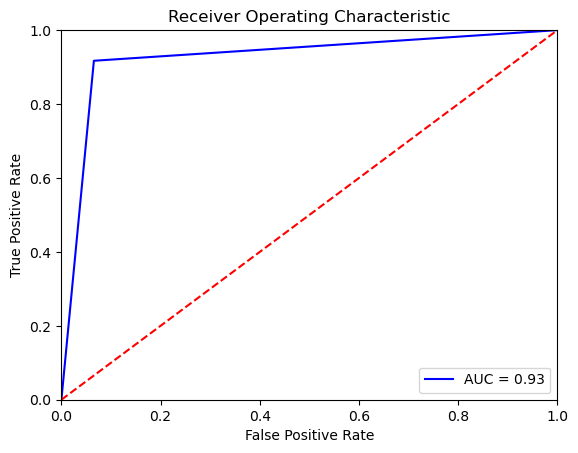

In [54]:
# Calculate the FPR and TPR for all thresholds of the classification
probs = randforest.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, y_predicted)
roc_auc = metrics.auc(fpr, tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

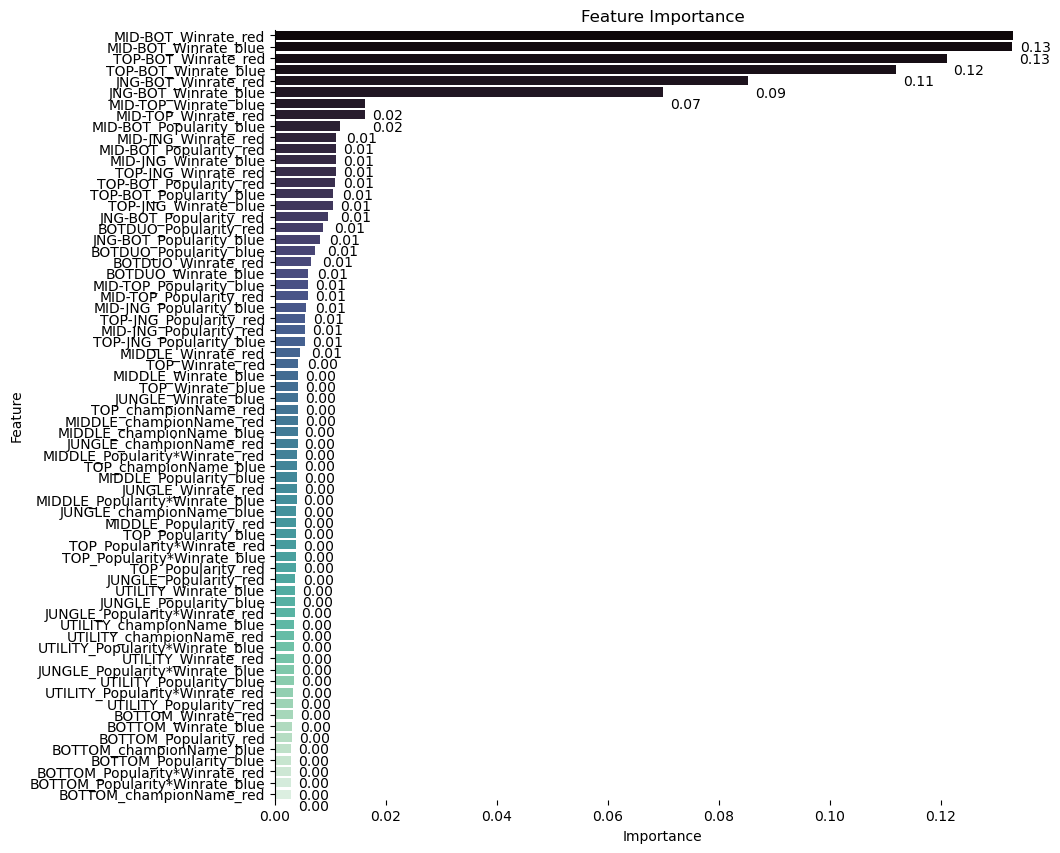

In [55]:
# Plot feature importance

# Create a dataframe of feature importance
feature_imp = pd.DataFrame(randforest.feature_importances_, X_test.columns, columns=['Importance'])

# Filter out importance levels that equal 0 and sort by descending
feature_imp = feature_imp[feature_imp['Importance'] != 0]\
                            .sort_values('Importance', ascending = False)

# Plot

fig, ax = plt.subplots(figsize = (10, 10))

ax = sns.barplot(data    = feature_imp,
                 x       = 'Importance',
                 y       = feature_imp.index,
                 orient  = 'h',
                 palette = 'mako')

for p in ax.patches:    
    ax.annotate("%.2f" % p.get_width(), 
                   (p.get_x() + p.get_width(), 
                    p.get_y()), 
                    xytext=(5, -15), 
                    textcoords='offset points')


ax.set_yticks(np.arange(len(feature_imp)))
ax.set_yticklabels(feature_imp.index)
ax.set_xlabel('Importance')
ax.set_ylabel('Feature')
ax.set_title('Feature Importance')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)


plt.show()

# Test on live matches/ external data

In [56]:
def input_champion_names():
    champion_names = {
        'top-blueside': None,
        'jungle-blueside': None,
        'mid-blueside': None,
        'adc-blueside': None,
        'support-blueside': None,
        'top-redside': None,
        'jungle-redside': None,
        'mid-redside': None,
        'adc-redside': None,
        'support-redside': None,
    }

    for role in champion_names.keys():
        champion_name = input(f"Enter the champion name for {role}: ")
        champion_names[role] = champion_name

    champion_df = pd.DataFrame([champion_names])
    return champion_df

In [66]:
# download champion data to input correctly
champs = pd.DataFrame(unique_champions)
champs =  champs.to_csv("champs.csv", index=False)

### Enter champions from any match to test model predictions below

In [249]:
game = pd.DataFrame(columns=x_var)
champion_names = input_champion_names()
game['BOTTOM_championName_blue'] = champion_names['adc-blueside'].map(champion_to_number)
game['UTILITY_championName_blue'] = champion_names['support-blueside'].map(champion_to_number)
game['MIDDLE_championName_blue'] = champion_names['mid-blueside'].map(champion_to_number)
game['TOP_championName_blue'] = champion_names['top-blueside'].map(champion_to_number)
game['JUNGLE_championName_blue'] = champion_names['jungle-blueside'].map(champion_to_number)

game['BOTTOM_championName_red'] = champion_names['adc-redside'].map(champion_to_number)
game['UTILITY_championName_red'] = champion_names['support-redside'].map(champion_to_number)
game['MIDDLE_championName_red'] = champion_names['mid-redside'].map(champion_to_number)
game['TOP_championName_red'] = champion_names['top-redside'].map(champion_to_number)
game['JUNGLE_championName_red'] = champion_names['jungle-redside'].map(champion_to_number)

game['BOTTOM_Winrate_red'] = champion_names['adc-redside'].map(win_rates)
game['JUNGLE_Winrate_red'] = champion_names['jungle-redside'].map(win_rates)
game['MIDDLE_Winrate_red'] = champion_names['mid-redside'].map(win_rates)
game['TOP_Winrate_red'] = champion_names['top-redside'].map(win_rates)
game['UTILITY_Winrate_red'] = champion_names['support-redside'].map(win_rates)

game['BOTTOM_Winrate_blue'] = champion_names['adc-blueside'].map(win_rates)
game['UTILITY_Winrate_blue'] = champion_names['support-blueside'].map(win_rates)
game['MIDDLE_Winrate_blue'] = champion_names['mid-blueside'].map(win_rates)
game['TOP_Winrate_blue'] = champion_names['top-blueside'].map(win_rates)
game['JUNGLE_Winrate_blue'] = champion_names['jungle-blueside'].map(win_rates)

game['BOTTOM_Popularity_red'] = champion_names['adc-redside'].map(pick_rate_indvidual)
game['JUNGLE_Popularity_red'] = champion_names['jungle-redside'].map(pick_rate_indvidual)
game['MIDDLE_Popularity_red'] = champion_names['mid-redside'].map(pick_rate_indvidual)
game['TOP_Popularity_red'] = champion_names['top-redside'].map(pick_rate_indvidual)
game['UTILITY_Popularity_red'] = champion_names['support-redside'].map(pick_rate_indvidual)

game['BOTTOM_Popularity_blue'] = champion_names['adc-blueside'].map(pick_rate_indvidual)
game['UTILITY_Popularity_blue'] = champion_names['support-blueside'].map(pick_rate_indvidual)
game['MIDDLE_Popularity_blue'] = champion_names['mid-blueside'].map(pick_rate_indvidual)
game['TOP_Popularity_blue'] = champion_names['top-blueside'].map(pick_rate_indvidual)
game['JUNGLE_Popularity_blue'] = champion_names['jungle-blueside'].map(pick_rate_indvidual)

game['BOTTOM_Popularity*Winrate_red'] = game['BOTTOM_Popularity_red'] * game['BOTTOM_Winrate_red']
game['JUNGLE_Popularity*Winrate_red'] = game['JUNGLE_Popularity_red'] * game['JUNGLE_Winrate_red']
game['MIDDLE_Popularity*Winrate_red'] = game['MIDDLE_Popularity_red'] * game['MIDDLE_Winrate_red']
game['TOP_Popularity*Winrate_red'] = game['TOP_Popularity_red'] * game['TOP_Winrate_red']
game['UTILITY_Popularity*Winrate_red'] = game['UTILITY_Popularity_red'] * game['UTILITY_Winrate_red']

game['BOTTOM_Popularity*Winrate_blue'] = game['BOTTOM_Popularity_blue'] * game['BOTTOM_Winrate_blue']
game['JUNGLE_Popularity*Winrate_blue'] = game['JUNGLE_Popularity_blue'] * game['JUNGLE_Winrate_blue']
game['MIDDLE_Popularity*Winrate_blue'] = game['MIDDLE_Popularity_blue'] * game['MIDDLE_Winrate_blue']
game['TOP_Popularity*Winrate_blue'] = game['TOP_Popularity_blue'] * game['TOP_Winrate_blue']
game['UTILITY_Popularity*Winrate_blue'] = game['UTILITY_Popularity_blue'] * game['UTILITY_Winrate_blue']


champion_names['JNG_BOT_blue'] = champion_names['jungle-blueside'] + '_' + champion_names['adc-blueside'] + '_' + champion_names['support-blueside']
champion_names['JNG_BOT_red'] = champion_names['jungle-redside'] + '_' + champion_names['adc-redside'] + '_' + champion_names['support-redside']

champion_names['MID_JNG_blue'] = champion_names['mid-blueside'] + '_' + champion_names['jungle-blueside'] 
champion_names['MID_JNG_red'] = champion_names['mid-redside'] + '_' + champion_names['jungle-redside']

champion_names['MID_TOP_blue'] = champion_names['mid-blueside'] + '_' + champion_names['top-blueside'] 
champion_names['MID_TOP_red'] = champion_names['mid-redside'] + '_' + champion_names['top-redside']

champion_names['MID_BOT_blue'] = champion_names['mid-blueside'] + '_' + champion_names['adc-blueside'] + '_' + champion_names['support-blueside']
champion_names['MID_BOT_red'] = champion_names['mid-redside'] + '_' + champion_names['adc-redside'] + '_' + champion_names['support-redside']

champion_names['TOP_BOT_blue'] = champion_names['top-blueside'] + '_' + champion_names['adc-blueside'] + '_' + champion_names['support-blueside']
champion_names['TOP_BOT_red'] = champion_names['top-redside'] + '_' + champion_names['adc-redside'] + '_' + champion_names['support-redside']
      
champion_names['TOP_JNG_blue'] = champion_names['top-blueside'] + '_' + champion_names['jungle-blueside'] 
champion_names['TOP_JNG_red'] = champion_names['top-redside'] + '_' + champion_names['jungle-redside']

champion_names['BOTDUO_blue'] = champion_names['adc-blueside'] + '_' + champion_names['support-blueside'] 
champion_names['BOTDUO_red'] = champion_names['adc-redside'] + '_' + champion_names['support-redside']

game['JNG-BOT_Popularity_red'] = champion_names['JNG_BOT_red'].map(pick_rate_jungle_bot)
game['JNG-BOT_Winrate_red'] = champion_names['JNG_BOT_red'].map(JUNGLE_bot_lane_win_rates)
game['JNG-BOT_Popularity_blue'] = champion_names['JNG_BOT_blue'].map(pick_rate_jungle_bot)
game['JNG-BOT_Winrate_blue'] = champion_names['JNG_BOT_blue'].map(JUNGLE_bot_lane_win_rates)

game['MID-JNG_Popularity_red'] = champion_names['MID_JNG_red'].map(pick_rate_mid_jungle)
game['MID-JNG_Winrate_red'] = champion_names['MID_JNG_red'].map(MIDDLE_Jungle_win_rates)
game['MID-JNG_Popularity_blue'] = champion_names['MID_JNG_blue'].map(pick_rate_mid_jungle)
game['MID-JNG_Winrate_blue'] = champion_names['MID_JNG_blue'].map(MIDDLE_Jungle_win_rates)

game['MID-TOP_Popularity_red'] = champion_names['MID_TOP_red'].map(pick_rate_mid_top)
game['MID-TOP_Winrate_red'] = champion_names['MID_TOP_red'].map(MIDDLE_TOP_win_rates)
game['MID-TOP_Popularity_blue'] = champion_names['MID_TOP_blue'].map(pick_rate_mid_top)
game['MID-TOP_Winrate_blue'] = champion_names['MID_TOP_blue'].map(MIDDLE_TOP_win_rates)

game['MID-BOT_Popularity_red'] = champion_names['MID_BOT_red'].map(pick_rate_mid_bot)
game['MID-BOT_Winrate_red'] = champion_names['MID_BOT_red'].map(MIDDLE_bot_lane_win_rates)
game['MID-BOT_Popularity_blue'] = champion_names['MID_BOT_blue'].map(pick_rate_mid_bot)
game['MID-BOT_Winrate_blue'] = champion_names['MID_BOT_blue'].map(MIDDLE_bot_lane_win_rates)

game['TOP-JNG_Popularity_red'] = champion_names['TOP_JNG_red'].map(pick_rate_top_jungle)
game['TOP-JNG_Winrate_red'] = champion_names['TOP_JNG_red'].map(Top_Jungle_win_rates)
game['TOP-JNG_Popularity_blue'] = champion_names['TOP_JNG_blue'].map(pick_rate_top_jungle)
game['TOP-JNG_Winrate_blue'] = champion_names['TOP_JNG_blue'].map(Top_Jungle_win_rates)

game['BOTDUO_Popularity_red'] = champion_names['BOTDUO_red'].map(pick_rate_botduo)
game['BOTDUO_Winrate_red'] = champion_names['BOTDUO_red'].map(bot_lane_win_rates)
game['BOTDUO_Popularity_blue'] = champion_names['BOTDUO_blue'].map(pick_rate_botduo)
game['BOTDUO_Winrate_blue'] = champion_names['BOTDUO_blue'].map(bot_lane_win_rates)

game['TOP-BOT_Popularity_red'] = champion_names['TOP_BOT_red'].map(pick_rate_top_bot)
game['TOP-BOT_Winrate_red'] = champion_names['TOP_BOT_red'].map(TOP_bot_lane_win_rates)
game['TOP-BOT_Popularity_blue'] = champion_names['TOP_BOT_blue'].map(pick_rate_top_bot)
game['TOP-BOT_Winrate_blue'] = champion_names['TOP_BOT_blue'].map(TOP_bot_lane_win_rates)

columns_to_check_pop = [
    'JNG-BOT_Popularity_blue',
    'MID-JNG_Popularity_blue',
    'MID-TOP_Popularity_blue',
    'MID-BOT_Popularity_blue',       
    'TOP-BOT_Popularity_blue',
    'TOP-JNG_Popularity_blue',
    'BOTDUO_Popularity_blue',
    'JNG-BOT_Popularity_red',
    'MID-JNG_Popularity_red',
    'MID-TOP_Popularity_red',
    'MID-BOT_Popularity_red',      
    'TOP-BOT_Popularity_red',
    'TOP-JNG_Popularity_red',
    'BOTDUO_Popularity_red'
]

columns_to_check_wr = [
    'JNG-BOT_Winrate_blue',
    'MID-JNG_Winrate_blue',
    'MID-TOP_Winrate_blue',
    'MID-BOT_Winrate_blue',       
    'TOP-BOT_Winrate_blue',
    'TOP-JNG_Winrate_blue',
    'BOTDUO_Winrate_blue',
    'JNG-BOT_Winrate_red',
    'MID-JNG_Winrate_red',
    'MID-TOP_Winrate_red',
    'MID-BOT_Winrate_red',      
    'TOP-BOT_Winrate_red',
    'TOP-JNG_Winrate_red',
    'BOTDUO_Winrate_red'
]

for column in columns_to_check_pop:
    if column in game.columns:
        game[column].fillna(0, inplace=True)

for column in columns_to_check_wr:
    if column in game.columns:
        game[column].fillna(0.5, inplace=True)



Enter the champion name for top-blueside: Karma
Enter the champion name for jungle-blueside: Gragas
Enter the champion name for mid-blueside: Rengar
Enter the champion name for adc-blueside: Tristana
Enter the champion name for support-blueside: Senna
Enter the champion name for top-redside: KSante
Enter the champion name for jungle-redside: JarvanIV
Enter the champion name for mid-redside: Ekko
Enter the champion name for adc-redside: Kaisa
Enter the champion name for support-redside: Taric


In [250]:
game.to_csv("game.csv", index=False)

In [251]:
pd.set_option('display.max_columns', None)

In [252]:
game.head()

,JNG-BOT_Popularity_blue,JNG-BOT_Winrate_blue,MID-JNG_Popularity_blue,MID-JNG_Winrate_blue,MID-TOP_Popularity_blue,MID-TOP_Winrate_blue,MID-BOT_Popularity_blue,MID-BOT_Winrate_blue,BOTTOM_Popularity_blue,JUNGLE_Popularity_blue,MIDDLE_Popularity_blue,TOP_Popularity_blue,UTILITY_Popularity_blue,BOTTOM_Popularity*Winrate_blue,JUNGLE_Popularity*Winrate_blue,MIDDLE_Popularity*Winrate_blue,TOP_Popularity*Winrate_blue,UTILITY_Popularity*Winrate_blue,TOP-BOT_Popularity_blue,TOP-BOT_Winrate_blue,TOP-JNG_Popularity_blue,TOP-JNG_Winrate_blue,BOTTOM_Winrate_blue,JUNGLE_Winrate_blue,MIDDLE_Winrate_blue,TOP_Winrate_blue,UTILITY_Winrate_blue,BOTDUO_Popularity_blue,BOTDUO_Winrate_blue,BOTTOM_championName_blue,JUNGLE_championName_blue,MIDDLE_championName_blue,TOP_championName_blue,UTILITY_championName_blue,JNG-BOT_Popularity_red,JNG-BOT_Winrate_red,MID-JNG_Popularity_red,MID-JNG_Winrate_red,MID-TOP_Popularity_red,MID-TOP_Winrate_red,MID-BOT_Popularity_red,MID-BOT_Winrate_red,BOTTOM_Popularity_red,JUNGLE_Popularity_red,MIDDLE_Popularity_red,TOP_Popularity_red,UTILITY_Popularity_red,BOTTOM_Popularity*Winrate_red,JUNGLE_Popularity*Winrate_red,MIDDLE_Popularity*Winrate_red,TOP_Popularity*Winrate_red,UTILITY_Popularity*Winrate_red,TOP-BOT_Popularity_red,TOP-BOT_Winrate_red,TOP-JNG_Popularity_red,TOP-JNG_Winrate_red,BOTTOM_Winrate_red,JUNGLE_Winrate_red,MIDDLE_Winrate_red,TOP_Winrate_red,UTILITY_Winrate_red,BOTDUO_Popularity_red,BOTDUO_Winrate_red,BOTTOM_championName_red,JUNGLE_championName_red,MIDDLE_championName_red,TOP_championName_red,UTILITY_championName_red
0,0.000025,0.5,0.000013,0.0,0.0,0.5,0.0,0.5,0.112256,0.065117,0.068013,0.07556,0.071511,0.056655,0.031769,0.035342,0.03652,0.035668,0.0,0.5,0.000025,0.5,0.504691,0.487871,0.519631,0.483325,0.498773,0.001003,0.5625,35,112,7,9,100,0.000113,0.666667,0.001404,0.482143,0.000915,0.424658,0.000038,0.333333,0.315029,0.090843,0.090103,0.072564,0.024698,0.156261,0.045246,0.044882,0.034502,0.012575,0.00005,0.5,0.002369,0.449735,0.49602,0.498068,0.498122,0.475466,0.509137,0.003297,0.509506,15,55,91,85,153


In [253]:
game.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 68 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   JNG-BOT_Popularity_blue          1 non-null      float64
 1   JNG-BOT_Winrate_blue             1 non-null      float64
 2   MID-JNG_Popularity_blue          1 non-null      float64
 3   MID-JNG_Winrate_blue             1 non-null      float64
 4   MID-TOP_Popularity_blue          1 non-null      float64
 5   MID-TOP_Winrate_blue             1 non-null      float64
 6   MID-BOT_Popularity_blue          1 non-null      float64
 7   MID-BOT_Winrate_blue             1 non-null      float64
 8   BOTTOM_Popularity_blue           1 non-null      float64
 9   JUNGLE_Popularity_blue           1 non-null      float64
 10  MIDDLE_Popularity_blue           1 non-null      float64
 11  TOP_Popularity_blue              1 non-null      float64
 12  UTILITY_Popularity_blue   

In [254]:
# train model on full data
randforest = RandomForestClassifier()
randforest.fit(x_data, y_data)

# Predict on testset
y_predicted = randforest.predict(game)


In [255]:
y_predicted

array([False])

In [256]:
# train model on full data
logreg = LogisticRegression()
logreg.fit(x_data, y_data)

# Predict on testset
y_predicted1 = logreg.predict(game)

C:\Users\arpan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [257]:
y_predicted1

array([False])